# Quickstart: オフ方策評価とオフ方策選択(離散空間, 発展的内容)
このノートブックでは推薦システム人工データセット上で **オフ方策学習(OPE)とオフ方策選択(OPS)** より発展的なの内容やその活用例を紹介します．

特に、以下の3つの順番で解説していきます: 
1. セットアップ，人工データの生成とオフライン強化学習
2. 様々なオフ方策評価 (方策価値推定，累積分布関数推定)
3. オフ方策選択

このライブラリは，オンラインとオフラインの方策学習およびモデルベースのオフ方策評価の一部で [d3rlpy](https://github.com/takuseno/d3rlpy)のアルゴリズムを利用しています．
また、実装のワークフローは[Open Bandit Pipeline](https://github.com/st-tech/zr-obp)を参考にしています．

In [2]:
# SCOPE-RL モジュールのインポート
import scope_rl
from recgym import RECEnv
from scope_rl.dataset import SyntheticDataset
from scope_rl.policy import OnlineHead
from scope_rl.policy import EpsilonGreedyHead
from scope_rl.policy import SoftmaxHead
from scope_rl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)

# d3rlpy アルゴリズムのインポート
from d3rlpy.algos import DiscreteRandomPolicy as RandomPolicy
from d3rlpy.preprocessing import MinMaxObservationScaler

# その他のライブラリのインポート
import gym
import torch

In [3]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
# バージョン
print(scope_rl.__version__)

0.1.2


In [5]:
# random stateの設定
random_state = 12345

In [6]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [7]:
# logディレクトリ
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

In [8]:
# warnings
import warnings
warnings.simplefilter('ignore')

## 1. セットアップ，人工データの生成とオフライン強化学習
まず初めに推薦システム環境を紹介します．

#### 強化学習でのベーシック環境のセットアップ
推薦システムにおいて, 強化学習エージェントの目的は累積報酬を最大化することです．
この問題を(部分観測)マルコフ決定過程((PO)MDP)として定式化します．
- `状態`: 
   - ユーザーの好みを表すベクトル．好みはRLエージェントが提示する行動によってエピソードの中で時間と共に変化する.
   - 真の状態が観測できない場合，エージェントは状態の代わりに観測を用いる．
- `行動`: どのアイテムをユーザに提示するかを表す．
- `報酬`: ユーザーの関連シグナル．binary または continuous．


より詳細に環境の引数を確認したい場合は，次のノートブックを参照してください．[examples/quickstart_ja/rec/rec_synthetic_customize_env_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rec/rec_synthetic_customize_env_ja.ipynb).

In [9]:
# 標準的な環境
env = gym.make("RECEnv-v0")

#### 人工データ生成
オフ方策評価の目標は，過去に集められたデータを用いて新たな方策を評価することです．
そこで次のステップとして、データ収集方策$\pi_0$によりデータセットを収集します（今回はシミュレーション環境をオンライン環境とみなした人工データです）．

$$\mathcal{D}_0 := \{ \{ s_t, a_t, s_{t+1}, r_t \}_{t=1}^T \}_{i=1}^n \sim \prod_{i=1}^n d_{s_0}(s_0) \prod_{t=1}^T \pi_0(a_t | s_t) p(s_{t+1} | s_t, a_t) p(r_t | s_t, a_t),$$

ここで $s_t \in \mathcal{S}$ は時刻$t$で観測された状態，$a_t$ はデータ収集方策 $\pi_0$によって選択された行動，$r_t$は状態と行動に応じて観測された報酬を表します．

`SyntheticDataset` は以下の引数を持っています：
- `env`: 強化学習の（シミュレーション）環境．
- `max_episode_steps`: 一つのエピソードにおける連続意思決定の数（上限）．

より詳細にデータ収集と可視化について知りたい場合は，以下を参照してください．[examples/quickstart/basic/basic_synthetic_data_collection_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_data_collection_ja.ipynb).

In [10]:
# データ収集方策
from d3rlpy.algos import DoubleDQNConfig
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.dataset import create_fifo_replay_buffer
from d3rlpy.algos import LinearDecayEpsilonGreedy

# モデル
ddqn = DoubleDQNConfig(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    target_update_interval=100,
).create(device=device)

# 再生バッファの設定
buffer = create_fifo_replay_buffer(
    limit=10000,
    env=env,
)
# 探索
explorer = LinearDecayEpsilonGreedy(
    start_epsilon=1.0,
    end_epsilon=0.1,
    duration=1000,
)

In [ ]:
# 学習の開始
# 事前学習したモデルを利用する場合はスキップ
ddqn.fit_online(
    env,
    buffer,
    explorer=explorer,
    eval_env=env,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

In [12]:
# モデルの保存
ddqn.save_model("d3rlpy_logs/ddqn.pt")

In [13]:
# モデルのリロード
ddqn.build_with_env(env)
ddqn.load_model("d3rlpy_logs/ddqn.pt")

2023-07-22 17:49:15 [warning  ] Parameters will be reinitialized.


In [14]:
behavior_policy = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.3,
    name="ddqn_epsilon_0.3",
    random_state=random_state,
)

In [15]:
# データセットクラスの初期化
dataset = SyntheticDataset(
    env=env,
    max_episode_steps=env.step_per_episode,
)

In [ ]:
# データ収集方策によってログデータを集める
# ログデータがある存在する場合はスキップ
train_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state,
)
test_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state + 1,
)

In [17]:
with open("logs/train_dataset_discrete_ddqn.pkl", "wb") as f:
    pickle.dump(train_logged_dataset, f)
with open("logs/test_dataset_discrete_ddqn.pkl", "wb") as f:
    pickle.dump(test_logged_dataset, f)

In [18]:
with open("logs/train_dataset_discrete_ddqn.pkl", "rb") as f:
    train_logged_dataset = pickle.load(f)
with open("logs/test_dataset_discrete_ddqn.pkl", "rb") as f:
    test_logged_dataset = pickle.load(f)

#### オフライン強化学習
さて，データ収集が済んだところで，[d3rlpy](https://github.com/takuseno/d3rlpy)のアルゴリズムを用いていくつかの"候補"方策を学習します．これは，オフ方策評価では評価対象となる新たな方策に対応します．

オフライン強化学習の手順について詳細に知りたい方は，以下を参照してください[examples/quickstart_ja/rec/rec_synthetic_discrete_basic_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rec/rec_synthetic_discrete_basic_ja.ipynb).

In [19]:
# d3rlpyのモジュールのインポート
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import DiscreteCQLConfig as CQLConfig
# d3rlpy用にオフラインデータセットを変形
offlinerl_dataset = MDPDataset(
    observations=train_logged_dataset["state"],
    actions=train_logged_dataset["action"],
    rewards=train_logged_dataset["reward"],
    terminals=train_logged_dataset["done"],
)

In [20]:
# Conservative Q-Learning (CQL) 方策を利用
# base policy 1: hidden_units = [30, 30]
cql_b1 = CQLConfig(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
).create(device=device)

In [ ]:
cql_b1.fit(
    offlinerl_dataset,
    n_steps=10000,
)

In [22]:
# モデルの保存
cql_b1.save_model("d3rlpy_logs/cql_discrete_b1.pt")

In [23]:
# モデルのリロード
cql_b1.build_with_env(env)
cql_b1.load_model("d3rlpy_logs/cql_discrete_b1.pt")

2023-07-22 17:51:35 [warning  ] Parameters will be reinitialized.


In [24]:
# Conservative Q-Learning (CQL) 方策を利用
# base policy 2: hidden_units = [100]
cql_b2 = CQLConfig(
    encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    q_func_factory=MeanQFunctionFactory(),
).create(device=device)

In [ ]:
cql_b2.fit(
    offlinerl_dataset,
    n_steps=10000,
)

In [26]:
# モデルの保存
cql_b2.save_model("d3rlpy_logs/cql_discrete_b2.pt")

In [27]:
# モデルのリロード
cql_b2.build_with_env(env)
cql_b2.load_model("d3rlpy_logs/cql_discrete_b2.pt")

2023-07-22 17:52:03 [warning  ] Parameters will be reinitialized.


In [28]:
# Conservative Q-Learning (CQL) 方策を利用
# base policy 3: hidden_units = [50, 10]
cql_b3 = CQLConfig(
    encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    q_func_factory=MeanQFunctionFactory(),
).create(device=device)

In [ ]:
cql_b3.fit(
    offlinerl_dataset,
    n_steps=10000,
)

In [30]:
# モデルの保存
cql_b3.save_model("d3rlpy_logs/cql_discrete_b3.pt")

In [31]:
# モデルのリロード
cql_b3.build_with_env(env)
cql_b3.load_model("d3rlpy_logs/cql_discrete_b3.pt")

2023-07-22 17:52:30 [warning  ] Parameters will be reinitialized.


## 2. 様々なオフ方策評価
評価対象の方策が学習できたところで，方策の性能指標となる様々な統計量を，オフ方策評価を用いて（オフラインで）推定していきます．

#### 標準的な推定

まずはオフ方策評価で一番標準的な，方策の期待性能 (*方策価値*) を推定します．

$$ V(\pi) := \mathbb{E}\left[\sum_{t=1}^T \gamma^{t-1} r_t \mid \pi \right] $$


In [32]:
# SCOPE-RLからのopeモジュールのインポート
from scope_rl.ope import CreateOPEInput
from scope_rl.ope import OffPolicyEvaluation as BasicOPE
from scope_rl.ope.discrete import DirectMethod as DM
from scope_rl.ope.discrete import TrajectoryWiseImportanceSampling as TIS
from scope_rl.ope.discrete import PerDecisionImportanceSampling as PDIS
from scope_rl.ope.discrete import DoublyRobust as DR
from scope_rl.ope.discrete import SelfNormalizedTIS as SNTIS
from scope_rl.ope.discrete import SelfNormalizedPDIS as SNPDIS
from scope_rl.ope.discrete import SelfNormalizedDR as SNDR

In [33]:
# 評価方策を定義 (epsilon-greedy and softmax)
cql_b1_00 = EpsilonGreedyHead(base_policy=cql_b1, n_actions=env.action_space.n, name="cql_b1_epsilon00", epsilon=0.0, random_state=random_state)
cql_b1_03 = EpsilonGreedyHead(base_policy=cql_b1, n_actions=env.action_space.n, name="cql_b1_epsilon03", epsilon=0.3, random_state=random_state)
cql_b1_07 = EpsilonGreedyHead(base_policy=cql_b1, n_actions=env.action_space.n, name="cql_b1_epsilon07", epsilon=0.7, random_state=random_state)
cql_b1_soft = SoftmaxHead(base_policy=cql_b1, n_actions=env.action_space.n, name="cql_b1_softmax", random_state=random_state)

cql_b2_00 = EpsilonGreedyHead(base_policy=cql_b2, n_actions=env.action_space.n, name="cql_b2_epsilon00", epsilon=0.0, random_state=random_state)
cql_b2_03 = EpsilonGreedyHead(base_policy=cql_b2, n_actions=env.action_space.n, name="cql_b2_epsilon03", epsilon=0.3, random_state=random_state)
cql_b2_07 = EpsilonGreedyHead(base_policy=cql_b2, n_actions=env.action_space.n, name="cql_b2_epsilon07", epsilon=0.7, random_state=random_state)
cql_b2_soft = SoftmaxHead(base_policy=cql_b2, n_actions=env.action_space.n, name="cql_b2_softmax", random_state=random_state)

cql_b3_00 = EpsilonGreedyHead(base_policy=cql_b3, n_actions=env.action_space.n, name="cql_b3_epsilon00", epsilon=0.0, random_state=random_state)
cql_b3_03 = EpsilonGreedyHead(base_policy=cql_b3, n_actions=env.action_space.n, name="cql_b3_epsilon03", epsilon=0.3, random_state=random_state)
cql_b3_07 = EpsilonGreedyHead(base_policy=cql_b3, n_actions=env.action_space.n, name="cql_b3_epsilon07", epsilon=0.7, random_state=random_state)
cql_b3_soft = SoftmaxHead(base_policy=cql_b3, n_actions=env.action_space.n, name="cql_b3_softmax", random_state=random_state)

evaluation_policies = [
    cql_b1_00, cql_b1_03, cql_b1_07, cql_b1_soft, 
    cql_b2_00, cql_b2_03, cql_b2_07, cql_b2_soft, 
    cql_b3_00, cql_b3_03, cql_b3_07, cql_b3_soft,
]

In [34]:
# まずOPEのインプットを準備
prep = CreateOPEInput(
    env=env,
    model_args={
        "fqe": {
            "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
            "q_func_factory": MeanQFunctionFactory(),
            "learning_rate": 1e-4,
        }
    },
    state_scaler=MinMaxObservationScaler(
        minimum=test_logged_dataset["state"].min(axis=0),
        maximum=test_logged_dataset["state"].max(axis=0),
    ),
)

In [ ]:
# 計算に時間がかかります
input_dict = prep.obtain_whole_inputs(
    logged_dataset=test_logged_dataset,
    evaluation_policies=evaluation_policies,
    require_value_prediction=True,
    n_trajectories_on_policy_evaluation=100,
    random_state=random_state,
)

In [36]:
with open("logs/ope_input_dict_discrete_advanced.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [37]:
with open("logs/ope_input_dict_discrete_advanced.pkl", "rb") as f:
    input_dict = pickle.load(f)

In [38]:
ope = BasicOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()],
)

In [39]:
# opeによる性能評価
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(input_dict, random_state=random_state)
# 性能推定結果（辞書）
policy_value_df_dict

{'cql_b1_epsilon00':            policy_value  relative_policy_value
 on_policy      1.483253               1.000000
 dm            97.054265              65.433369
 tis            1.809195               1.219748
 pdis           1.481130               0.998568
 dr            16.860173              11.367021
 sntis          3.364836               2.268551
 snpdis         1.700838               1.146694
 sndr         -61.777674             -41.650115,
 'cql_b1_epsilon03':            policy_value  relative_policy_value
 on_policy      0.869861               1.000000
 dm           129.863003             149.291704
 tis            0.972948               1.118510
 pdis           0.795551               0.914572
 dr             4.439693               5.103913
 sntis          1.179620               1.356102
 snpdis         0.795155               0.914117
 sndr         -26.111201             -30.017677,
 'cql_b1_epsilon07':            policy_value  relative_policy_value
 on_policy     -0.063467  

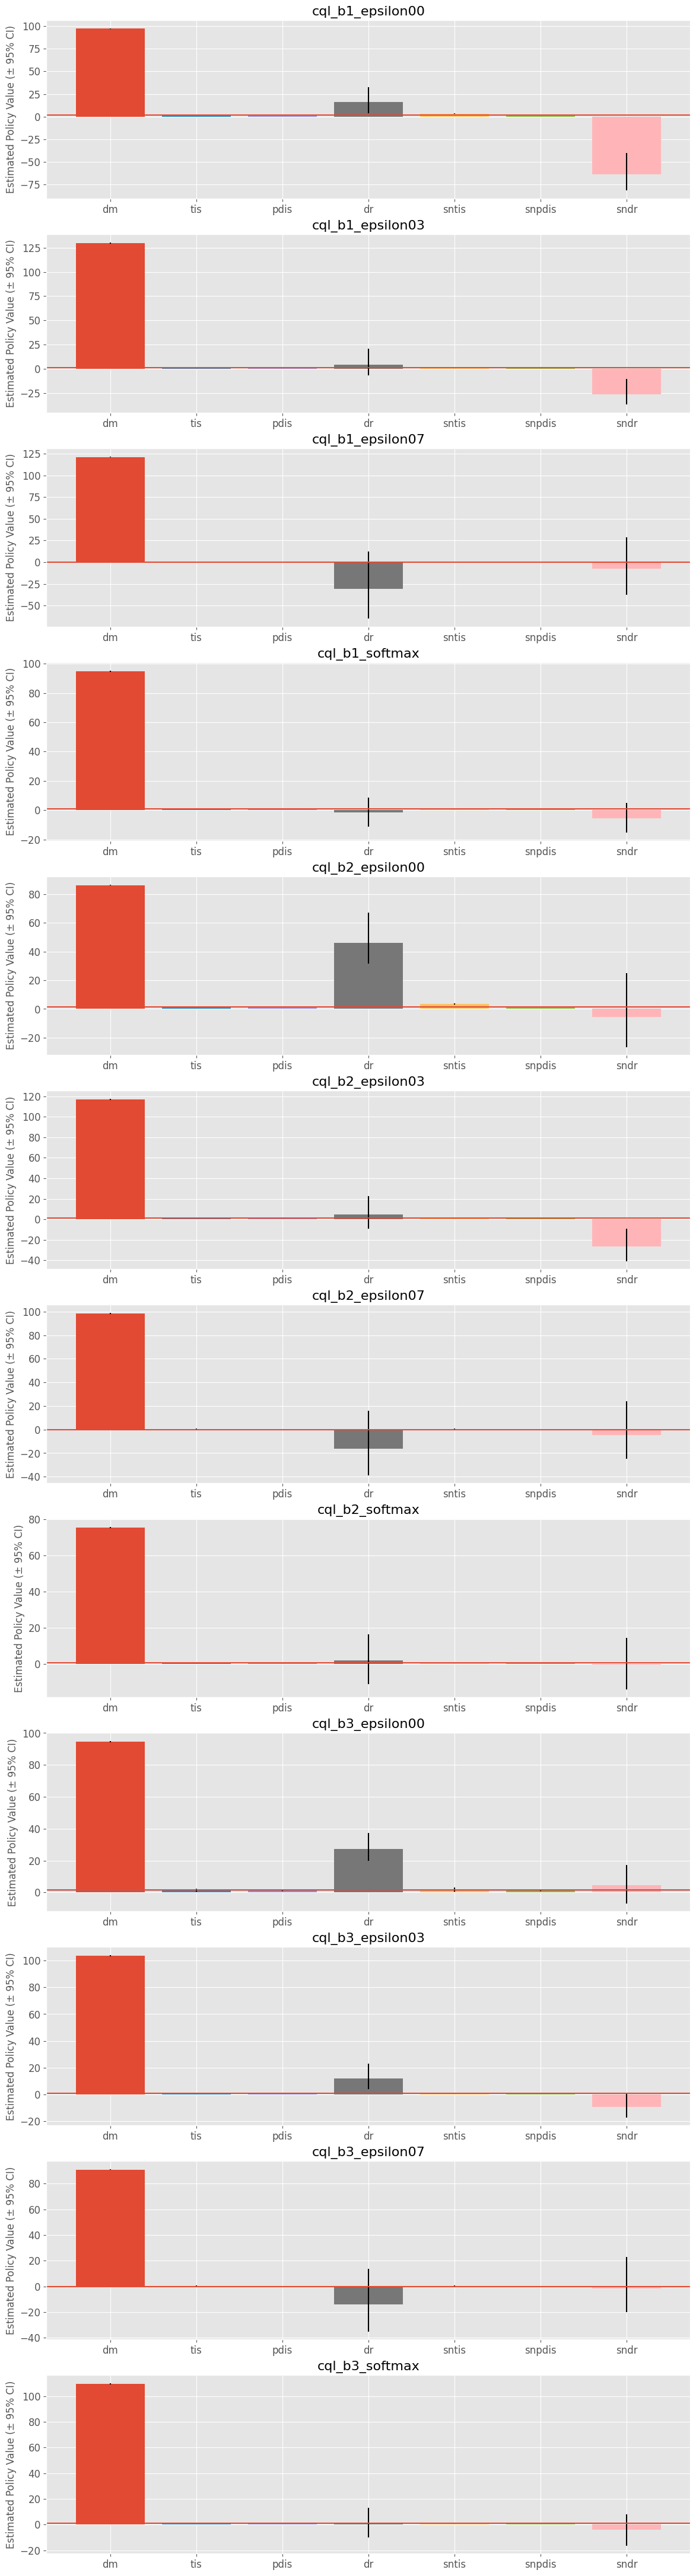

In [40]:
# opeの結果の比較・可視化
ope.visualize_off_policy_estimates(input_dict, random_state=random_state, sharey=False)
# データ収集方策に対する相対方策価値
# ope.visualize_off_policy_estimates(input_dict, random_state=random_state, is_relative=True, sharey=False)

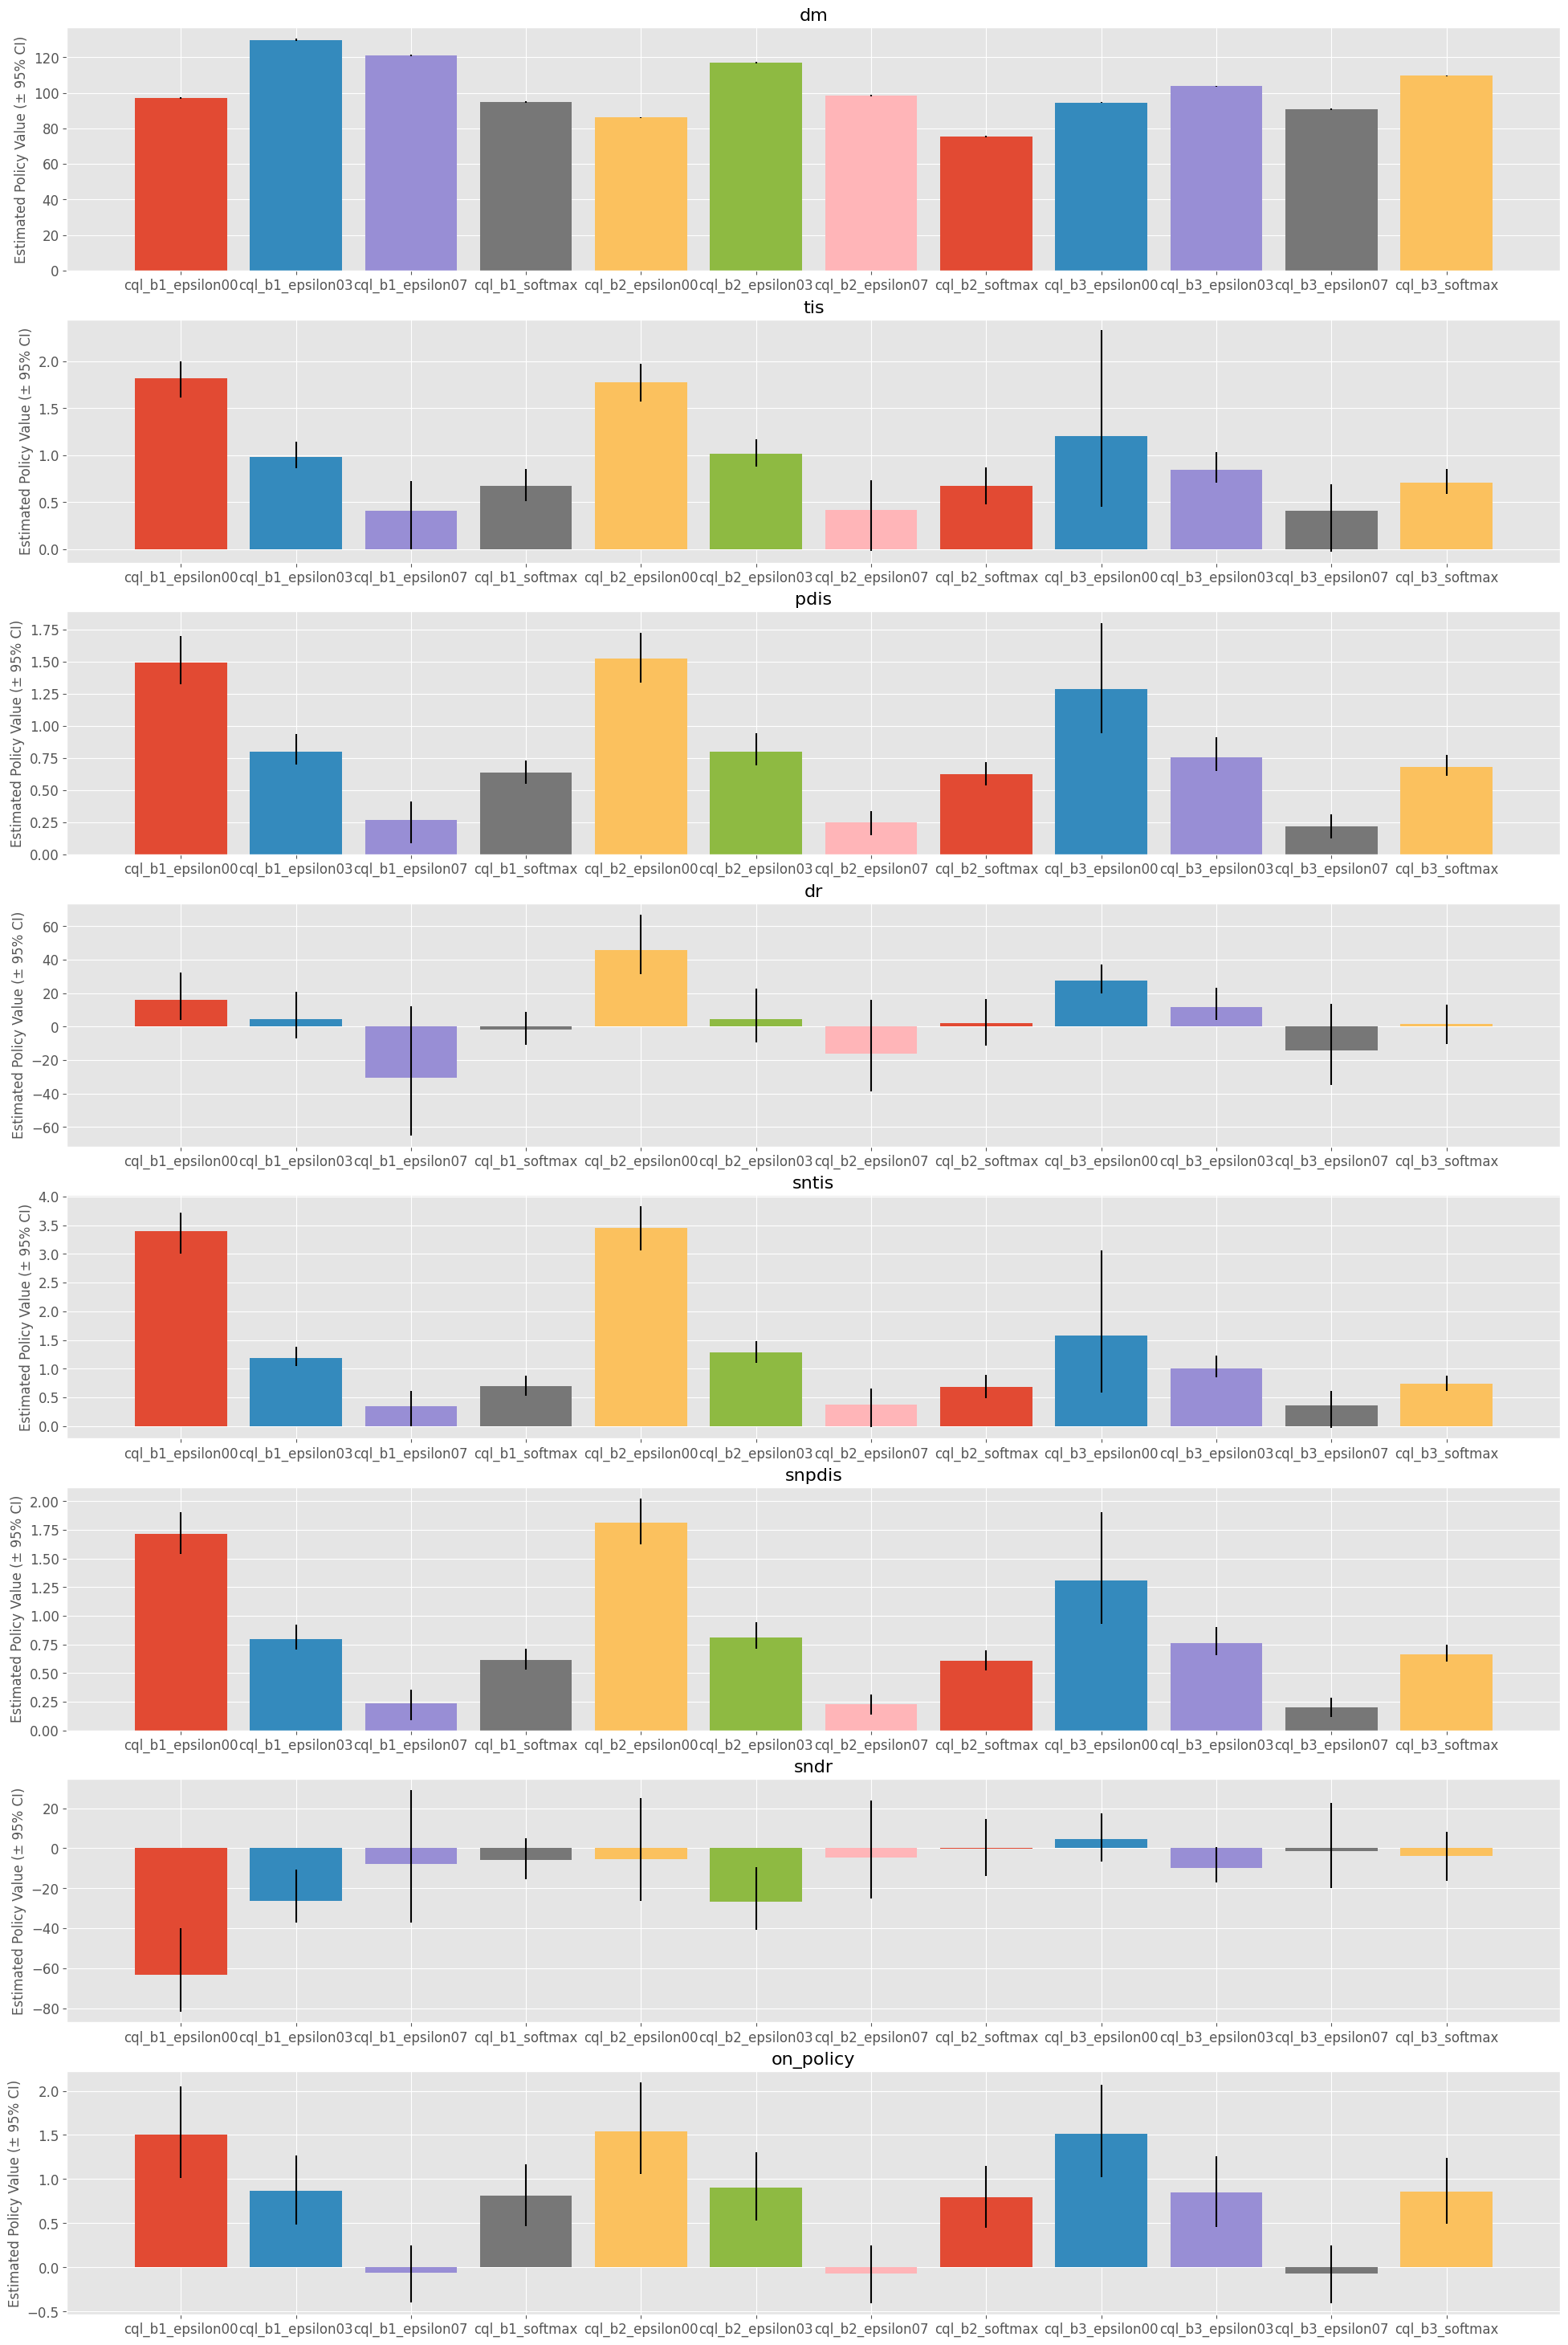

In [41]:
# OPE推定量の候補の方策価値を比較します
ope.visualize_off_policy_estimates(input_dict, random_state=random_state, hue="policy", sharey=False)
# データ収集方策に対する相対方策価値
# ope.visualize_off_policy_estimates(input_dict, random_state=random_state, is_relative=True, hue="policy", sharey=False)

#### 累積分布関数推定
次に，軌跡単位での報酬の累積分布関数に基づき，方策性能に関する様々な統計量を推定します．

$$ F(t, \pi) := \mathbb{E}\left[ \mathbb{I} \left \{ \sum_{t=1}^T \gamma^{t-1} r_t \leq t \right \} \mid \pi \right] $$

特に，上記の累積度数分布から，以下の性能指標を推定することができます．
- 累積分布関数
- 期待値 (方策価値)
- 分散
- CVaR (Conditional Value at Risk)
- 四分位範囲

In [42]:
from scope_rl.ope import CumulativeDistributionOPE
from scope_rl.ope.discrete import CumulativeDistributionDM as CD_DM
from scope_rl.ope.discrete import CumulativeDistributionTIS as CD_IS
from scope_rl.ope.discrete import CumulativeDistributionTDR as CD_DR
from scope_rl.ope.discrete import CumulativeDistributionSNTIS as CD_SNIS
from scope_rl.ope.discrete import CumulativeDistributionSNTDR as CD_SNDR

In [43]:
cd_ope = CumulativeDistributionOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[
        CD_DM(estimator_name="cdf_dm"), 
        CD_IS(estimator_name="cdf_is"), 
        CD_DR(estimator_name="cdf_dr"), 
        CD_SNIS(estimator_name="cdf_snis"), 
        CD_SNDR(estimator_name="cdf_sndr"),
    ],
)

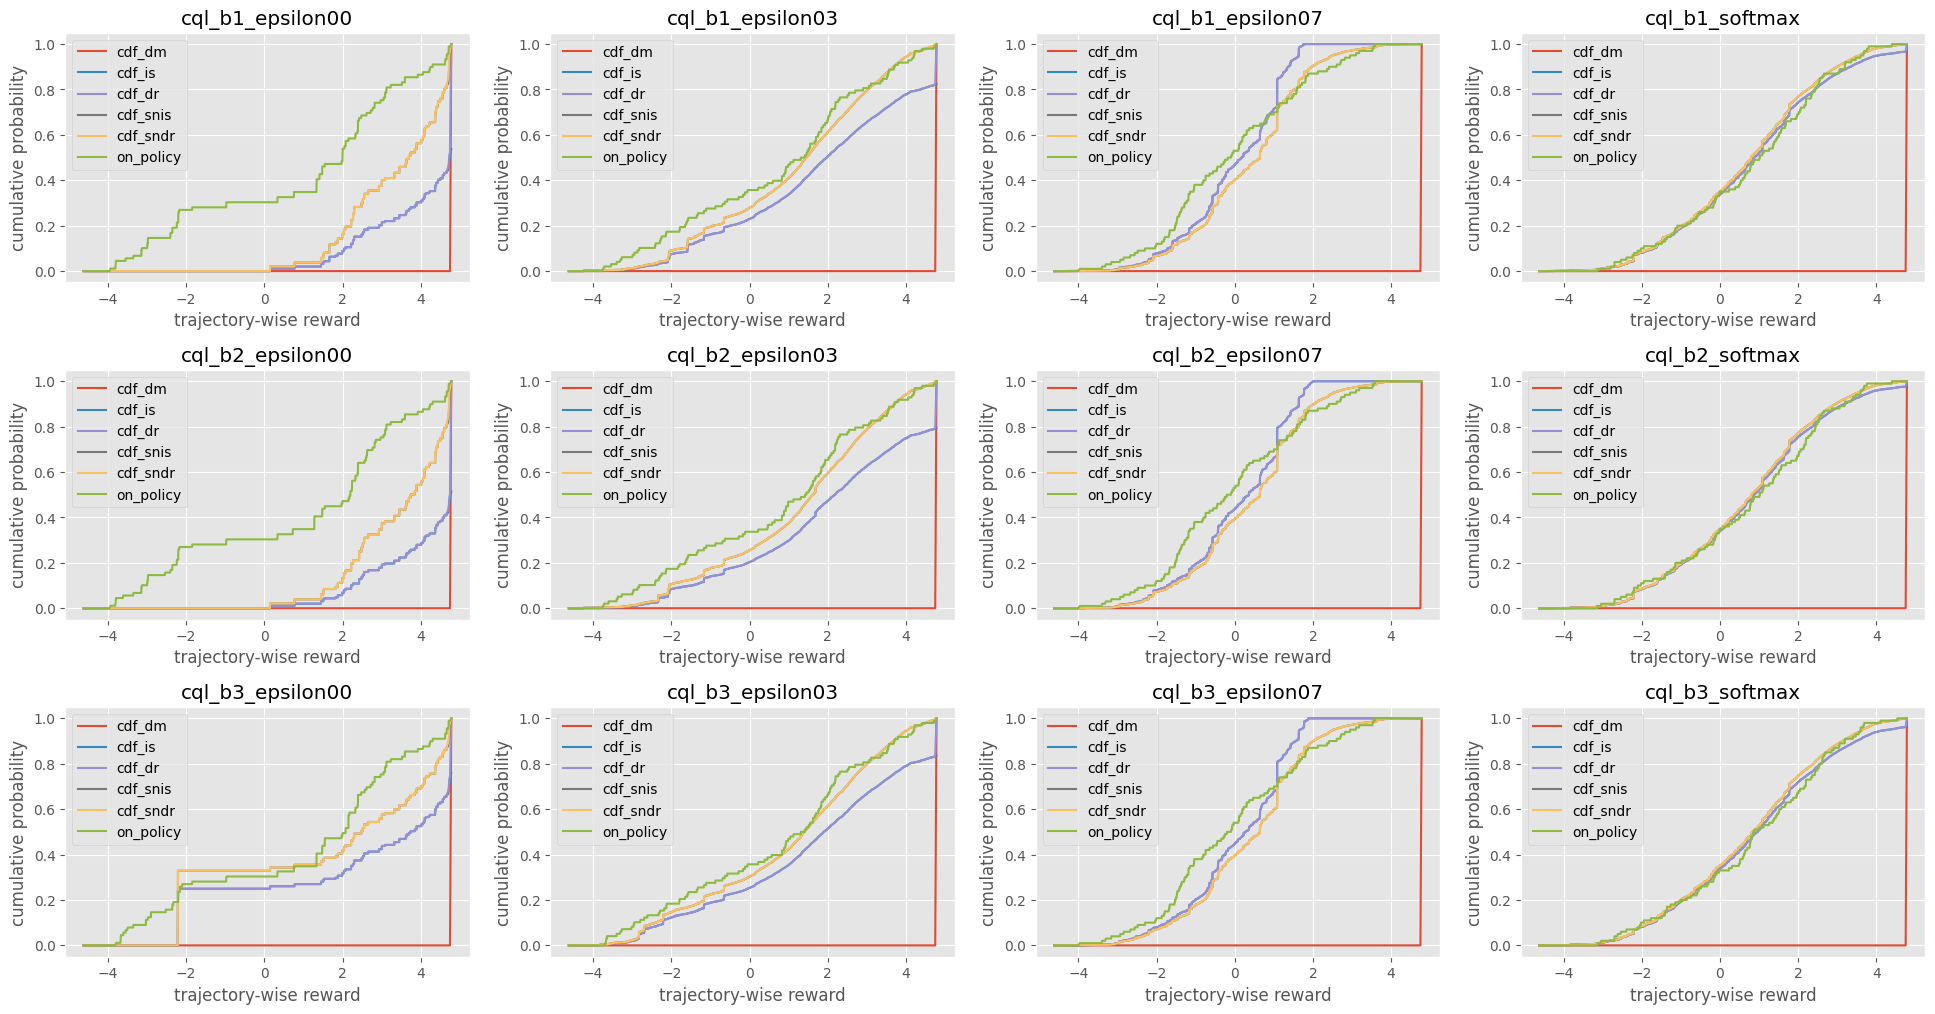

In [44]:
# 累積分布関数
cd_ope.visualize_cumulative_distribution_function(input_dict, n_cols=4)

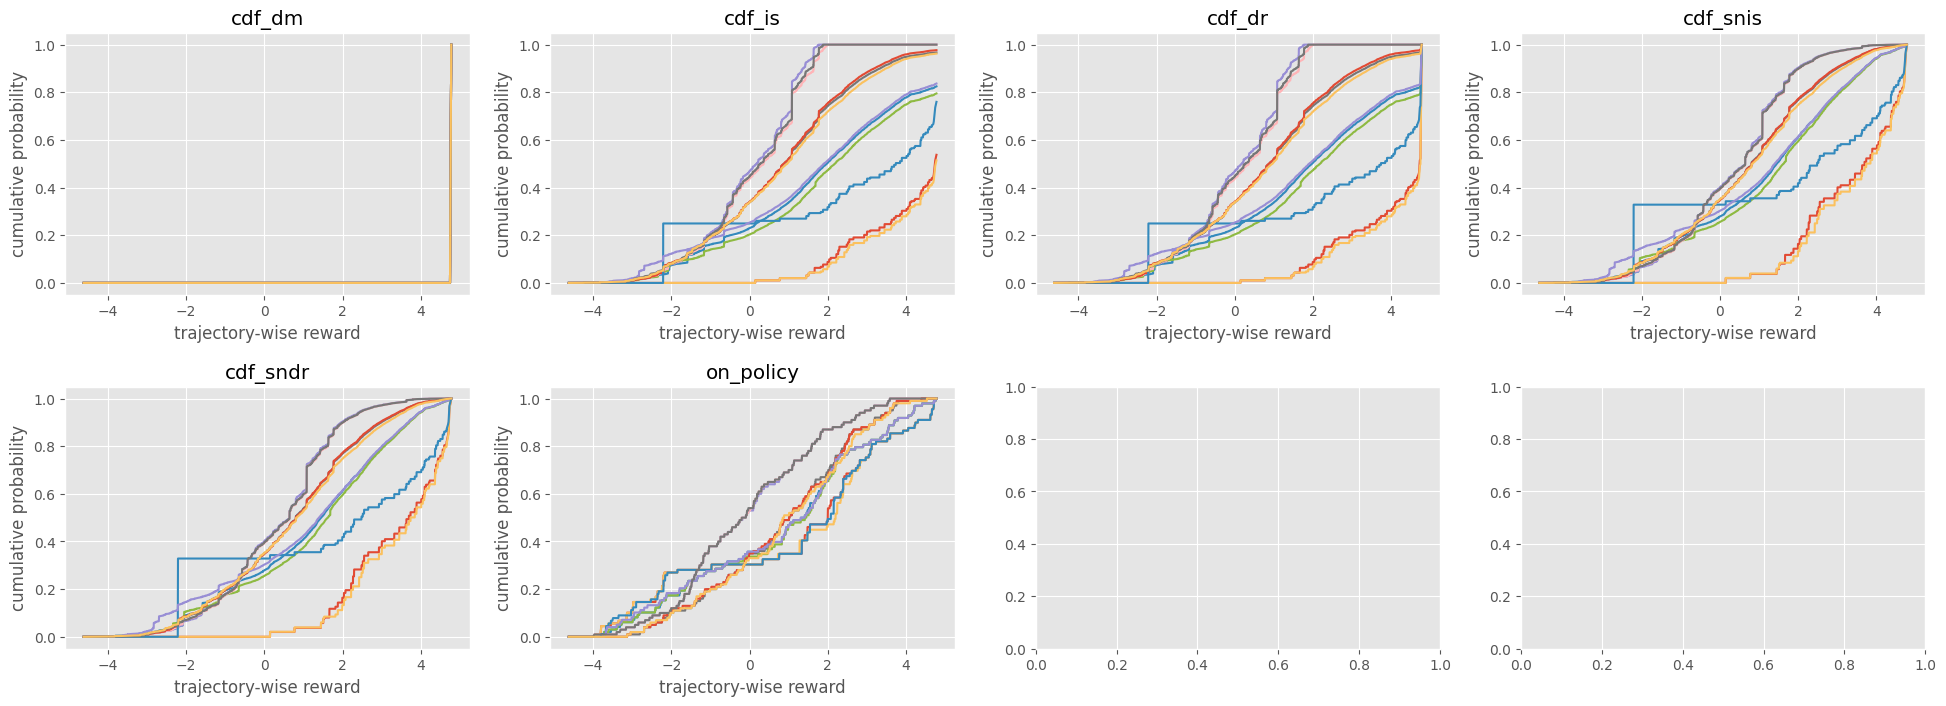

In [45]:
# それぞれのOPE推定量による累積分布関数の比較
# 凡例（評価方策の名前）は省略
cd_ope.visualize_cumulative_distribution_function(
    input_dict, 
    hue="policy",
    n_cols=4,
    legend=False,
)

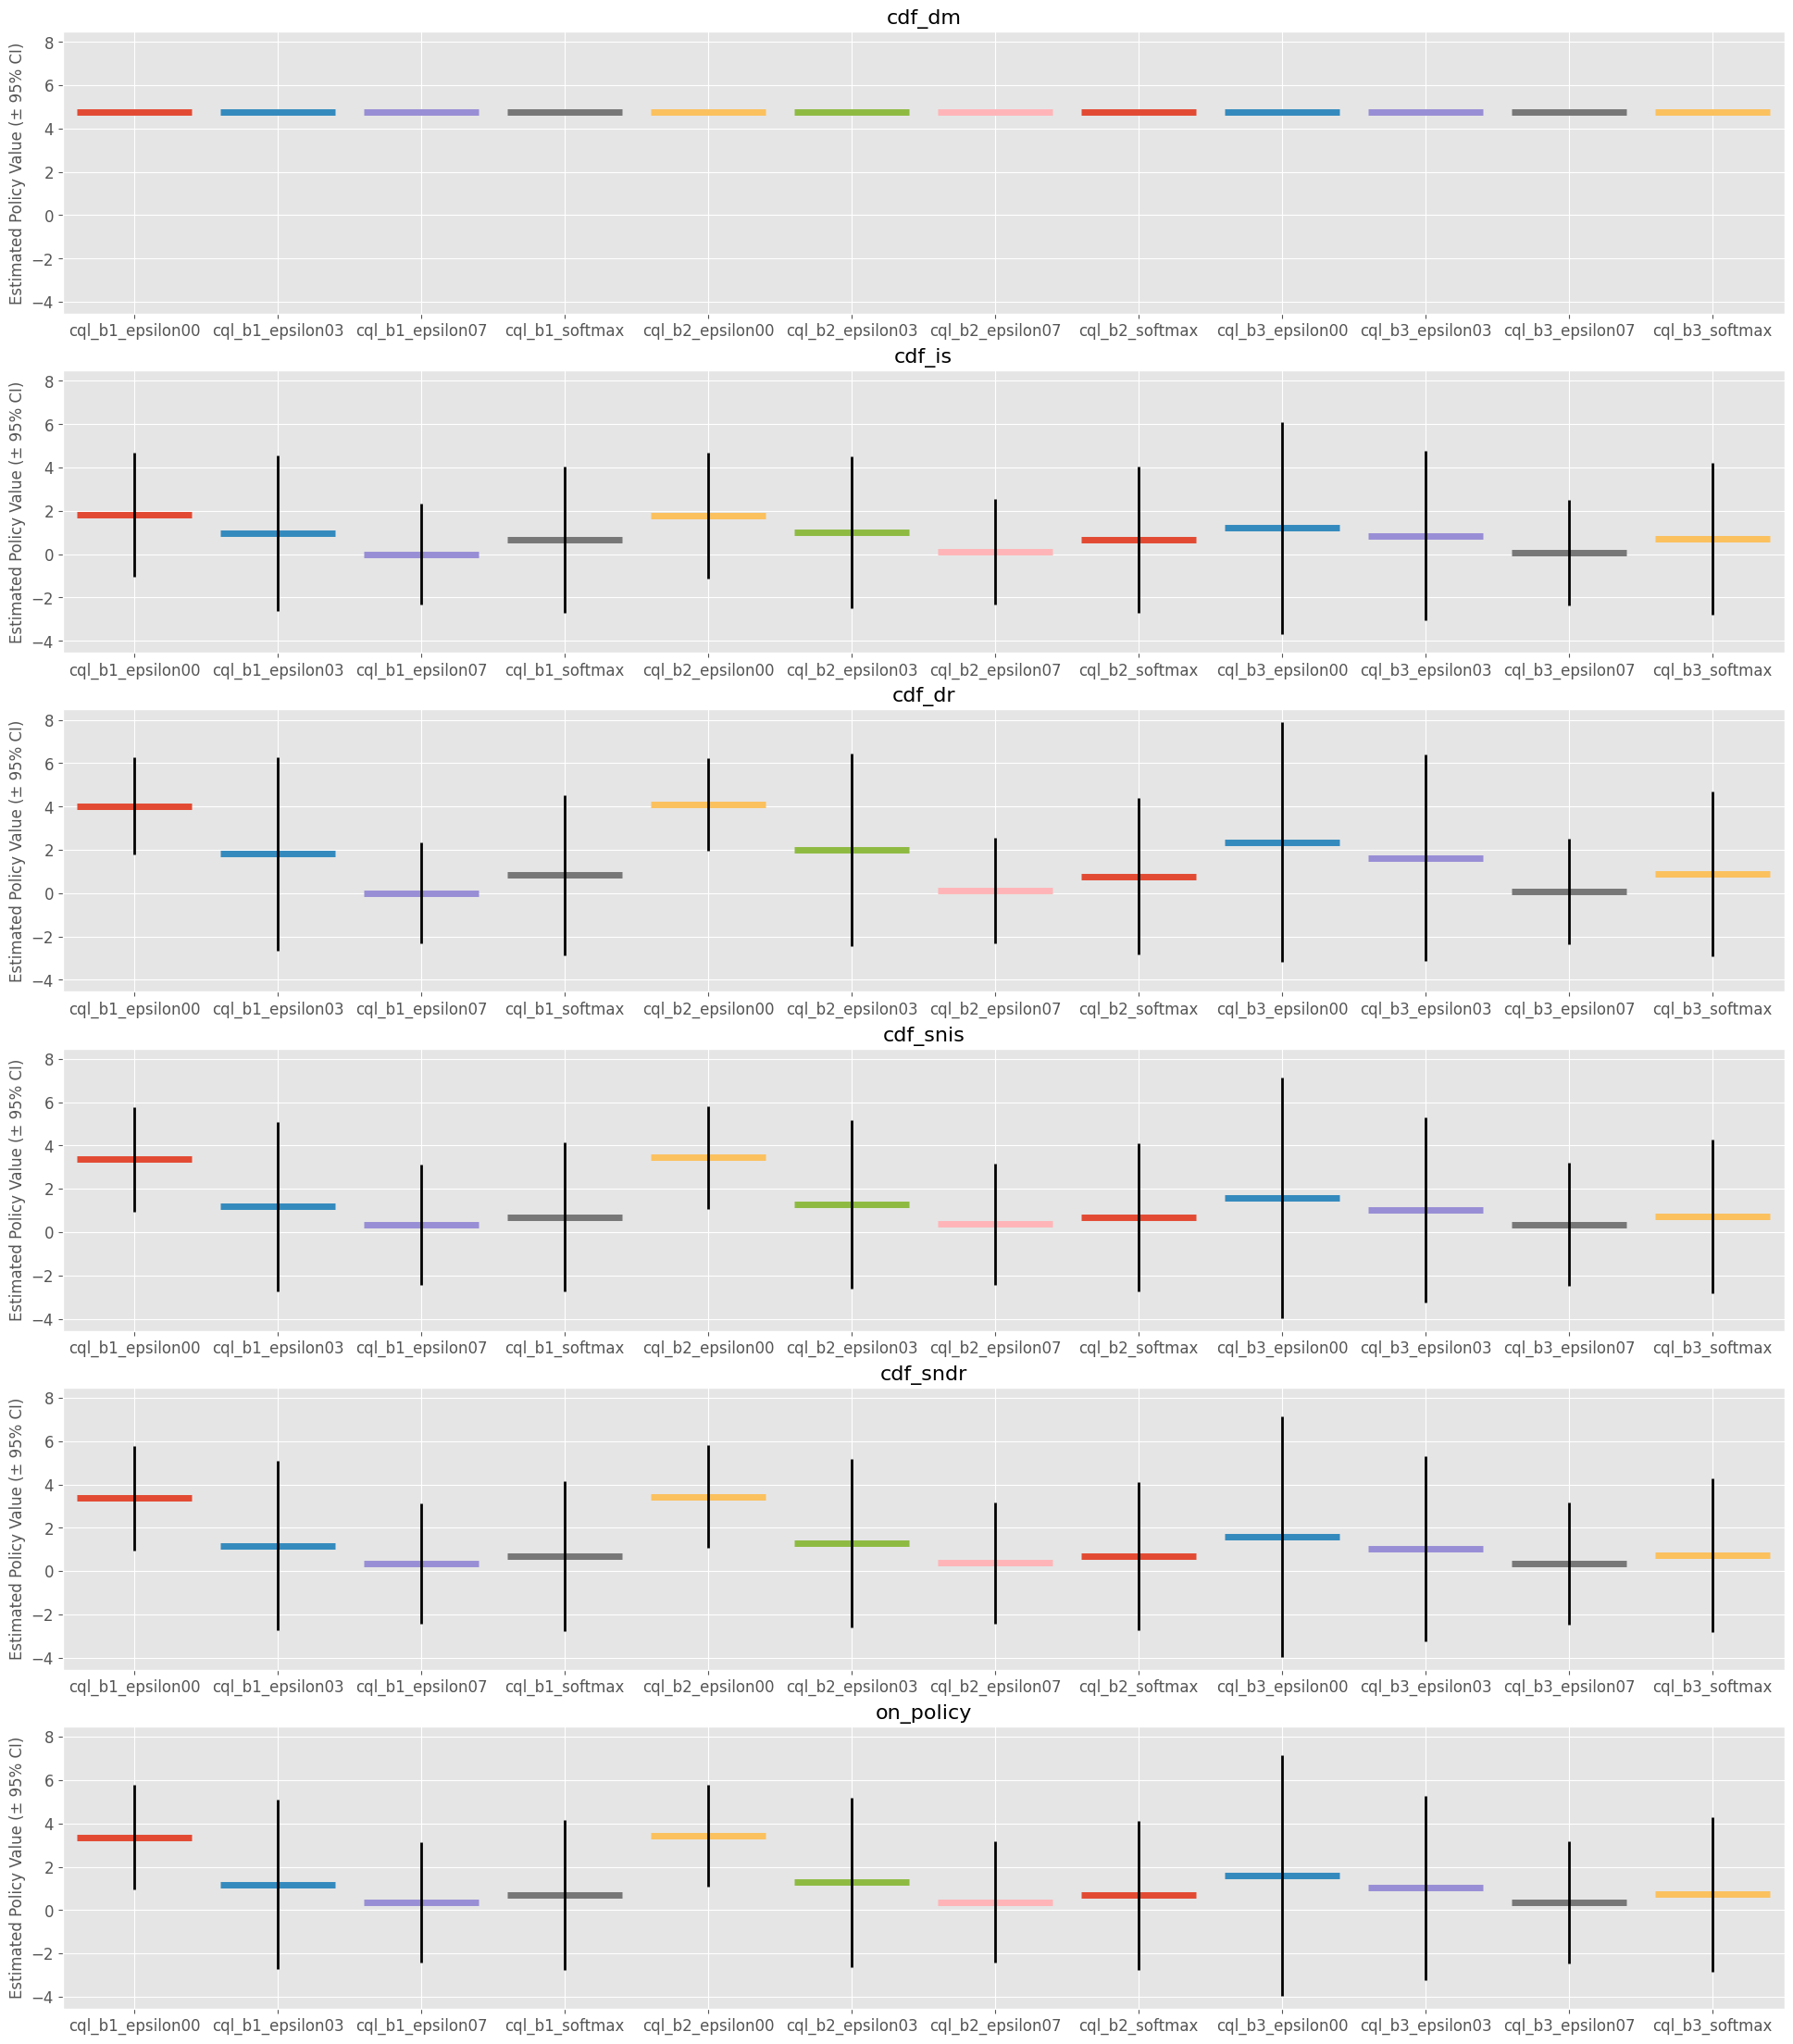

In [46]:
# 累積分布関数から求めた方策価値
mean_dict = cd_ope.estimate_mean(input_dict)
variance_dict = cd_ope.estimate_variance(input_dict)

# 平均と分散に基づく方策価値と信頼区間の可視化

# OPE推定量による候補方策間での比較
cd_ope.visualize_policy_value(input_dict, hue="policy", sharey=True)

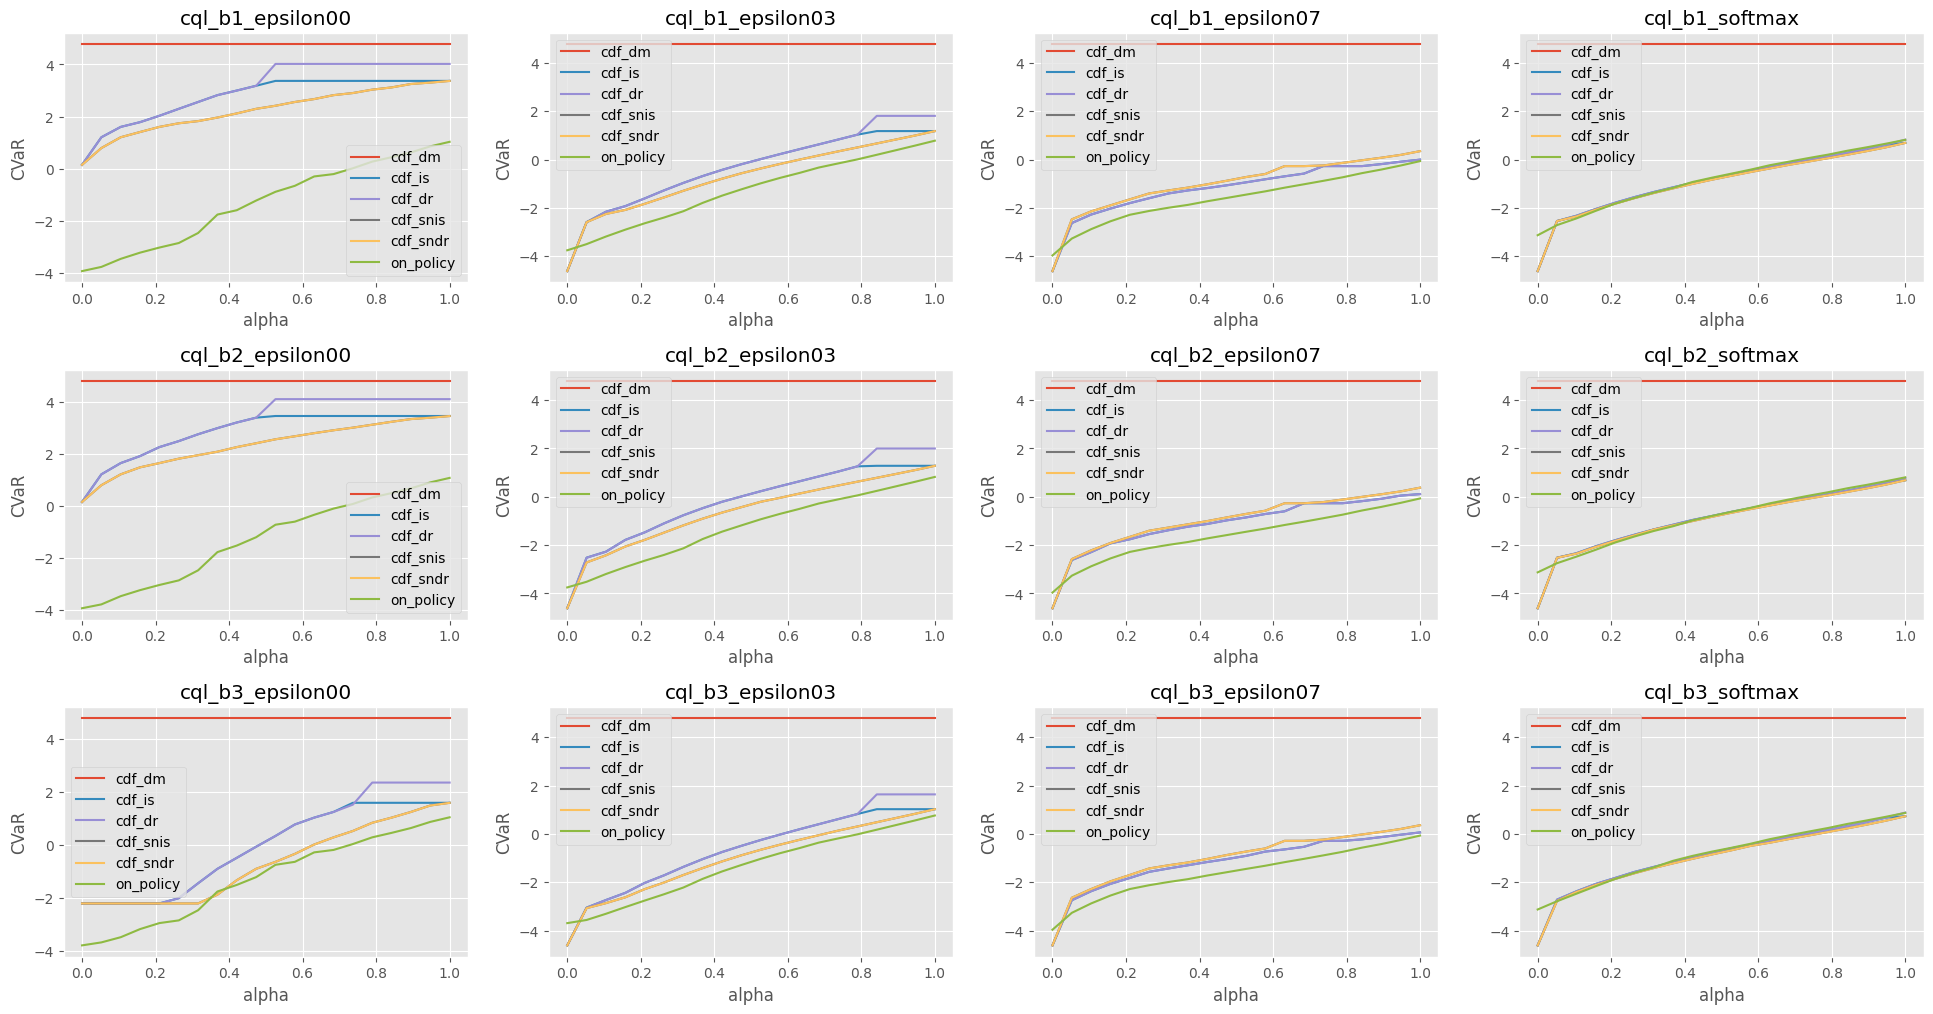

In [47]:
# conditional value at risk
cvar_dict = cd_ope.estimate_conditional_value_at_risk(input_dict, alphas=0.3)
# conditional value at riskの可視化
cd_ope.visualize_conditional_value_at_risk(input_dict, alphas=np.linspace(0, 1, 20), n_cols=4, sharey=True)

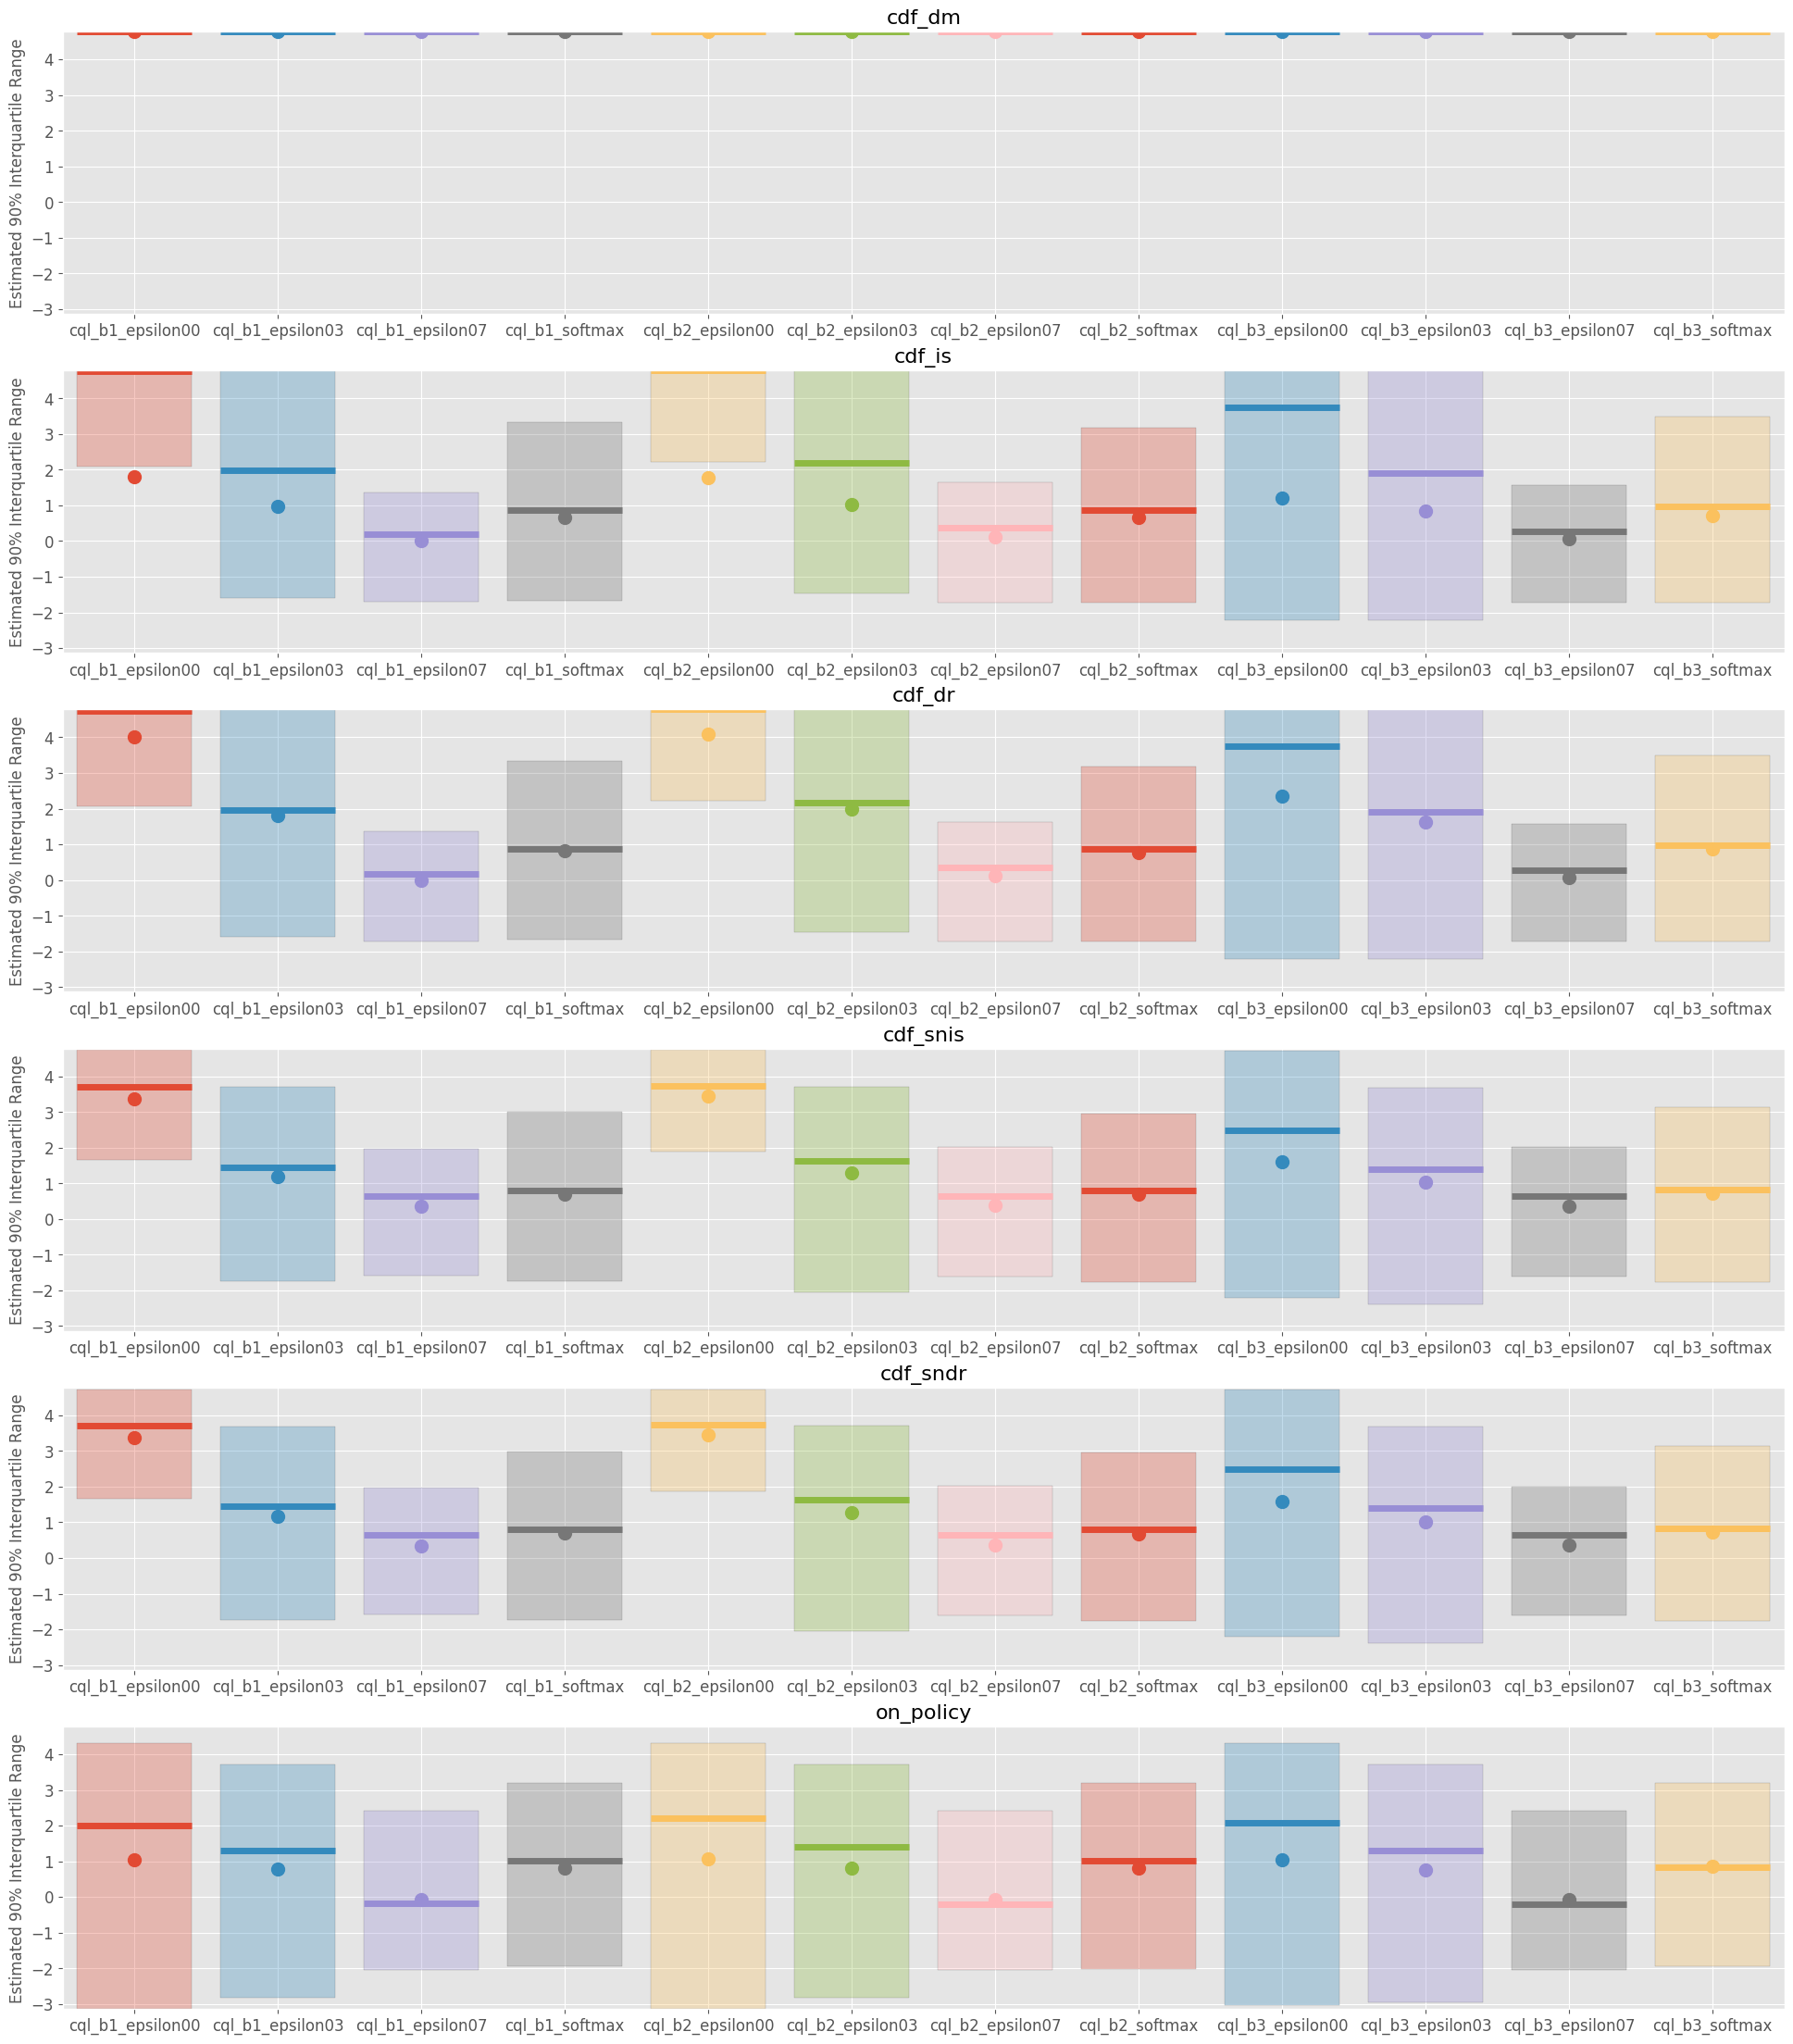

In [48]:
# 四分位範囲
interquartile_range_dict = cd_ope.estimate_interquartile_range(input_dict, alpha=0.10)
# OPE推定量による候補方策間での比較
cd_ope.visualize_interquartile_range(input_dict, alpha=0.10, hue="policy", sharey=True)

## 3. オフ方策選択

オフ方策選択の目的は，これまで推定してきた方策の性能指標に基づき，いくつかの候補方策の中からベストな方策を選択することです．これは，実際にどの方策を実環境にデプロイするか決定する手順に相当します．

In [49]:
from scope_rl.ope import OffPolicySelection

In [50]:
ops = OffPolicySelection(
    ope=ope,
    cumulative_distribution_ope=cd_ope,
)

In [51]:
ops.obtain_true_selection_result(
    input_dict=input_dict,
    return_variance=True,
    return_lower_quartile=True,
    return_conditional_value_at_risk=True,
    return_by_dataframe=True,
)

ranking  policy_value  relative_policy_value  variance  \
0   cql_b2_epsilon00      1.519276               2.157636  8.206380   
1   cql_b3_epsilon00      1.495896               2.124434  8.136060   
2   cql_b1_epsilon00      1.483253               2.106478  8.134738   
3   cql_b2_epsilon03      0.906203               1.286966  5.700877   
4   cql_b1_epsilon03      0.869861               1.235354  5.686981   
5     cql_b3_softmax      0.867521               1.232031  3.502580   
6   cql_b3_epsilon03      0.848019               1.204335  5.881565   
7     cql_b1_softmax      0.818040               1.161759  3.320285   
8     cql_b2_softmax      0.801524               1.138303  3.420899   
9   cql_b1_epsilon07     -0.063467              -0.090134  3.143935   
10  cql_b2_epsilon07     -0.071288              -0.101242  3.136859   
11  cql_b3_epsilon07     -0.072159              -0.102479  3.136775   

   ranking_by_lower_quartile  lower_quartile  \
0           cql_b1_epsilon00       -2.402398   
1           cql_b1_epsilon03       -2.402398   
2           cql_b1_epsilon07       -2.541161   
3             cql_b1_softmax       -2.847968   
4           cql_b2_epsilon00       -2.847968   
5           cql_b2_epsilon03       -2.847968   
6           cql_b2_epsilon07       -3.269371   
7             cql_b2_softmax       -3.272014   
8           cql_b3_epsilon00       -3.320345   
9           cql_b3_epsilon03       -3.362478   
10          cql_b3_epsilon07       -3.365826   
11            cql_b3_softmax       -3.550859   

   ranking_by_conditional_value_at_risk  conditional_value_at_risk  
0                        cql_b1_softmax                  -2.773925  
1                        cql_b2_softmax                  -2.820740  
2                        cql_b3_softmax                  -2.837210  
3                      cql_b3_epsilon07                  -3.360648  
4                      cql_b2_epsilon07                  -3.360648  
5                      cql_b1_epsilon07                  -3.360648  
6                      cql_b1_epsilon03                  -3.547613  
7                      cql_b2_epsilon03                  -3.570367  
8                      cql_b3_epsilon03                  -3.616922  
9                      cql_b3_epsilon00                  -3.686631  
10                     cql_b1_epsilon00                  -3.779153  
11                     cql_b2_epsilon00                  -3.792546

In [52]:
ranking_df, metric_df = ops.select_by_policy_value(
    input_dict=input_dict,
    return_true_values=True,
    return_metrics=True,
    return_by_dataframe=True,
)

In [53]:
ranking_df

{'dm':    estimated_ranking  estimated_policy_value  estimated_relative_policy_value  \
 0   cql_b1_epsilon03              129.863003                       184.428102   
 1   cql_b1_epsilon07              121.139455                       172.039143   
 2   cql_b2_epsilon03              117.116798                       166.326268   
 3     cql_b3_softmax              109.592687                       155.640720   
 4   cql_b3_epsilon03              103.796369                       147.408938   
 5   cql_b2_epsilon07               98.501375                       139.889123   
 6   cql_b1_epsilon00               97.054265                       137.833975   
 7     cql_b1_softmax               94.875944                       134.740379   
 8   cql_b3_epsilon00               94.587515                       134.330760   
 9   cql_b3_epsilon07               90.886875                       129.075206   
 10  cql_b2_epsilon00               86.109520                       122.290529   
 11    cql

In [54]:
metric_df

estimator  mean_squared_error  rank_correlation        pvalue  regret@1  \
0        dm        10384.245428         -0.020979  9.484022e-01  0.649415   
1       tis            0.086079          0.958042  9.543582e-07  0.036022   
2      pdis            0.039378          0.986014  4.116896e-09  0.000000   
3        dr          372.863846          0.895105  8.366586e-05  0.000000   
4     sntis            0.676560          0.965035  3.880985e-07  0.000000   
5    snpdis            0.046885          0.986014  4.116896e-09  0.000000   
6      sndr          485.547800         -0.307692  3.305893e-01  0.023379   

   type_i_error_rate  type_ii_error_rate  
0           0.000000                 1.0  
1           0.000000                 1.0  
2           0.000000                 1.0  
3           0.111111                 0.0  
4           0.000000                 1.0  
5           0.000000                 1.0  
6           0.888889                 0.0

In [55]:
ranking_df, metric_df = ops.select_by_policy_value_via_cumulative_distribution_ope(
    input_dict=input_dict,
    return_metrics=True,
    return_by_dataframe=True,
)

In [56]:
metric_df

estimator  mean_squared_error  rank_correlation        pvalue  regret@1  \
0    cdf_dm           16.295758         -1.000000  0.000000e+00  1.591435   
1    cdf_is            0.033278          0.944056  3.927261e-06  0.036022   
2    cdf_dr            1.378887          0.965035  3.880985e-07  0.000000   
3  cdf_snis            0.678920          0.965035  3.880985e-07  0.000000   
4  cdf_sndr            0.676561          0.965035  3.880985e-07  0.000000   

   type_i_error_rate  type_ii_error_rate  
0                0.0            1.000000  
1                0.0            0.666667  
2                0.0            0.666667  
3                0.0            1.000000  
4                0.0            1.000000

In [57]:
ranking_df, metric_df = ops.select_by_policy_value_lower_bound(
    input_dict=input_dict,
    cis=["bootstrap", "bernstein", "hoeffding", "ttest"],
    return_metrics=True,
    return_by_dataframe=True,
    random_state=12345,
)

In [58]:
metric_df

ci estimator  mean_squared_error  rank_correlation        pvalue  \
0   bootstrap        dm                 NaN         -0.020979  9.484022e-01   
1   bootstrap       tis                 NaN          0.566434  5.484212e-02   
2   bootstrap      pdis                 NaN          0.958042  9.543582e-07   
3   bootstrap        dr                 NaN          0.790210  2.223135e-03   
4   bootstrap     sntis                 NaN          0.699301  1.137420e-02   
5   bootstrap    snpdis                 NaN          0.965035  3.880985e-07   
6   bootstrap      sndr                 NaN         -0.097902  7.621217e-01   
7   bernstein        dm                 NaN         -0.020979  9.484022e-01   
8   bernstein       tis                 NaN          0.734266  6.543490e-03   
9   bernstein      pdis                 NaN          0.888112  1.141336e-04   
10  bernstein        dr                 NaN          0.832168  7.854417e-04   
11  bernstein     sntis                 NaN          0.769231  3.446450e-03   
12  bernstein    snpdis                 NaN          0.888112  1.141336e-04   
13  bernstein      sndr                 NaN         -0.314685  3.191388e-01   
14  hoeffding        dm                 NaN         -0.272727  3.910968e-01   
15  hoeffding       tis                 NaN          0.657343  2.018550e-02   
16  hoeffding      pdis                 NaN          0.692308  1.259303e-02   
17  hoeffding        dr                 NaN         -0.118881  7.128842e-01   
18  hoeffding     sntis                 NaN          0.489510  1.062524e-01   
19  hoeffding    snpdis                 NaN          0.692308  1.259303e-02   
20  hoeffding      sndr                 NaN         -0.419580  1.745190e-01   
21      ttest        dm                 NaN         -0.020979  9.484022e-01   
22      ttest       tis                 NaN          0.762238  3.950449e-03   
23      ttest      pdis                 NaN          0.958042  9.543582e-07   
24      ttest        dr                 NaN          0.902098  5.997857e-05   
25      ttest     sntis                 NaN          0.776224  2.992864e-03   
26      ttest    snpdis                 NaN          0.965035  3.880985e-07   
27      ttest      sndr                 NaN         -0.188811  5.567371e-01   

    regret@1  type_i_error_rate  type_ii_error_rate  
0   0.649415           0.000000                 1.0  
1   0.036022           0.000000                 1.0  
2   0.000000           0.000000                 1.0  
3   0.000000           0.666667                 0.0  
4   0.000000           0.000000                 1.0  
5   0.000000           0.000000                 1.0  
6   0.023379           1.000000                 0.0  
7   0.649415           0.000000                 1.0  
8   0.036022           0.222222                 0.0  
9   0.000000           0.000000                 0.0  
10  0.000000           0.777778                 0.0  
11  0.036022           0.222222                 0.0  
12  0.000000           0.000000                 0.0  
13  0.671257           1.000000                 0.0  
14  1.591435           1.000000                 0.0  
15  0.649415           1.000000                 0.0  
16  0.671257           1.000000                 0.0  
17  0.671257           1.000000                 0.0  
18  0.671257           1.000000                 0.0  
19  0.671257           1.000000                 0.0  
20  0.036022           1.000000                 0.0  
21  0.649415           0.000000                 1.0  
22  0.036022           0.000000                 1.0  
23  0.000000           0.000000                 1.0  
24  0.000000           0.555556                 0.0  
25  0.000000           0.000000                 1.0  
26  0.000000           0.000000                 1.0  
27  0.023379           1.000000                 0.0

In [59]:
ranking_df, metric_df = ops.select_by_lower_quartile(
    input_dict=input_dict,
    return_metrics=True,
    return_by_dataframe=True,
)

In [60]:
metric_df

estimator  mean_squared_error  rank_correlation    pvalue  regret  \
0    cdf_dm           60.741411         -1.000000  0.000000     NaN   
1    cdf_is            3.901420          0.741259  0.005801     NaN   
2    cdf_dr            3.899157          0.741259  0.005801     NaN   
3  cdf_snis            3.423763          0.650350  0.022034     NaN   
4  cdf_sndr            3.421043          0.650350  0.022034     NaN   

   type_i_error_rate  type_ii_error_rate  
0                0.0            1.000000  
1                0.0            0.166667  
2                0.0            0.166667  
3                0.0            0.166667  
4                0.0            0.166667

In [61]:
ranking_df, metric_df = ops.select_by_conditional_value_at_risk(
    input_dict=input_dict,
    return_metrics=True,
    return_by_dataframe=True,
)

In [62]:
metric_df

estimator  mean_squared_error  rank_correlation    pvalue  regret  \
0    cdf_dm           66.663441         -1.000000  0.000000     NaN   
1    cdf_is            4.637356         -0.363636  0.245265     NaN   
2    cdf_dr            4.634495         -0.363636  0.245265     NaN   
3  cdf_snis            3.986783         -0.524476  0.080019     NaN   
4  cdf_sndr            3.983832         -0.524476  0.080019     NaN   

   type_i_error_rate  type_ii_error_rate  
0                0.0            1.000000  
1                0.0            0.166667  
2                0.0            0.166667  
3                0.0            0.166667  
4                0.0            0.166667

In [63]:
topk_metric_df = ops.obtain_topk_policy_value_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    return_safety_violation_rate=True,
    relative_safety_criteria=1.0,
    return_by_dataframe=True,
)

In [64]:
topk_metric_df[:30]

estimator  topk      k-th      best     worst      mean       std  \
0         dm     0  0.869861  0.869861  0.869861  0.869861       NaN   
1         dm     1 -0.063467  0.869861 -0.063467  0.403197  0.659962   
2         dm     2  0.906203  0.906203 -0.063467  0.570866  0.549648   
3         dm     3  0.867521  0.906203 -0.063467  0.645029  0.472663   
4         dm     4  0.848019  0.906203 -0.063467  0.685627  0.419283   
5         dm     5 -0.071288  0.906203 -0.071288  0.559475  0.485928   
6         dm     6  1.483253  1.483253 -0.071288  0.691443  0.564518   
7         dm     7  0.818040  1.483253 -0.071288  0.707268  0.524555   
8         dm     8  1.495896  1.495896 -0.071288  0.794893  0.556658   
9         dm     9 -0.072159  1.495896 -0.072159  0.708188  0.592128   
10        dm    10  1.519276  1.519276 -0.072159  0.781923  0.612666   
11        dm    11  0.801524  1.519276 -0.072159  0.783556  0.584182   
0        tis     0  1.483253  1.483253  1.483253  1.483253       NaN   
1        tis     1  1.519276  1.519276  1.483253  1.501265  0.025472   
2        tis     2  1.495896  1.519276  1.483253  1.499475  0.018276   
3        tis     3  0.906203  1.519276  0.906203  1.351157  0.297011   
4        tis     4  0.869861  1.519276  0.869861  1.254898  0.335397   
5        tis     5  0.848019  1.519276  0.848019  1.187085  0.342906   
6        tis     6  0.867521  1.519276  0.848019  1.141433  0.335523   
7        tis     7  0.801524  1.519276  0.801524  1.098944  0.333070   
8        tis     8  0.818040  1.519276  0.801524  1.067732  0.325325   
9        tis     9 -0.071288  1.519276 -0.071288  0.953830  0.473089   
10       tis    10 -0.063467  1.519276 -0.071288  0.861349  0.543612   
11       tis    11 -0.072159  1.519276 -0.072159  0.783556  0.584182   
0       pdis     0  1.519276  1.519276  1.519276  1.519276       NaN   
1       pdis     1  1.483253  1.519276  1.483253  1.501265  0.025472   
2       pdis     2  1.495896  1.519276  1.483253  1.499475  0.018276   
3       pdis     3  0.906203  1.519276  0.906203  1.351157  0.297011   
4       pdis     4  0.869861  1.519276  0.869861  1.254898  0.335397   
5       pdis     5  0.848019  1.519276  0.848019  1.187085  0.342906   

    safety_violation_rate  sharpe_ratio  
0                0.000000           NaN  
1                0.500000      0.251108  
2                0.333333      0.367624  
3                0.250000      0.427501  
4                0.200000      0.481926  
5                0.333333      0.415831  
6                0.285714      1.380140  
7                0.250000      1.485285  
8                0.222222      1.422342  
9                0.300000      1.337139  
10               0.272727      1.330474  
11               0.250000      1.395348  
0                0.000000           NaN  
1                0.000000     32.001750  
2                0.000000     44.601798  
3                0.000000      2.744463  
4                0.000000      2.430365  
5                0.000000      2.377143  
6                0.000000      2.429449  
7                0.000000      2.447341  
8                0.000000      2.505608  
9                0.100000      1.723008  
10               0.181818      1.499484  
11               0.250000      1.395348  
0                0.000000           NaN  
1                0.000000     32.001750  
2                0.000000     44.601798  
3                0.000000      2.744463  
4                0.000000      2.430365  
5                0.000000      2.377143

In [65]:
topk_metric_df = ops.obtain_topk_policy_value_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    return_safety_violation_rate=True,
    relative_safety_criteria=1.0,
    return_by_dataframe=True,
)

In [66]:
topk_metric_df.head()

estimator  topk      k-th      best     worst      mean       std  \
0    cdf_dm     0  0.867521  0.867521  0.867521  0.867521       NaN   
1    cdf_dm     1 -0.072159  0.867521 -0.072159  0.397681  0.664454   
2    cdf_dm     2  0.848019  0.867521 -0.072159  0.547793  0.536983   
3    cdf_dm     3  1.495896  1.495896 -0.072159  0.784819  0.645724   
4    cdf_dm     4  0.801524  1.495896 -0.072159  0.788160  0.559263   

   safety_violation_rate  sharpe_ratio  
0               0.000000           NaN  
1               0.500000      0.245889  
2               0.333333      0.304258  
3               0.250000      1.226155  
4               0.200000      1.415716

In [67]:
topk_metric_df = ops.obtain_topk_policy_value_selected_by_lower_bound(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    return_safety_violation_rate=True,
    relative_safety_criteria=1.0,
    return_by_dataframe=True,
    random_state=random_state,
)

In [68]:
topk_metric_df.head()

ci estimator  topk      k-th      best     worst      mean  \
0  bootstrap        dm     0  1.495896  1.495896  1.495896  1.495896   
1  bootstrap        dm     1  1.483253  1.495896  1.483253  1.489575   
2  bootstrap        dm     2  0.867521  1.495896  0.867521  1.282223   
3  bootstrap        dm     3 -0.072159  1.495896 -0.072159  0.943628   
4  bootstrap        dm     4 -0.063467  1.495896 -0.072159  0.742209   

        std  safety_violation_rate  sharpe_ratio  
0       NaN                   0.00           NaN  
1  0.008940                   0.00     88.563573  
2  0.359199                   0.00      2.204232  
3  0.737973                   0.25      1.072881  
4  0.781857                   0.40      1.012662

In [69]:
topk_metric_df = ops.obtain_topk_conditional_value_at_risk_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_alpha=0.1,
    return_safety_violation_rate=True,
    safety_threshold=-1.0,
    return_by_dataframe=True,
)

In [70]:
topk_metric_df.head()

estimator  topk      k-th      best     worst      mean       std  \
0        dm     0 -3.263046 -3.263046 -3.263046 -3.263046       NaN   
1        dm     1 -2.966412 -2.966412 -3.263046 -3.114729  0.209752   
2        dm     2 -3.276767 -2.966412 -3.276767 -3.168741  0.175357   
3        dm     3 -2.529192 -2.529192 -3.276767 -3.008854  0.350365   
4        dm     4 -3.361053 -2.529192 -3.361053 -3.079294  0.341871   

   safety_violation_rate  sharpe_ratio  
0                    1.0           NaN  
1                    1.0      1.111932  
2                    1.0      1.330031  
3                    1.0      1.913573  
4                    1.0      1.961120

In [71]:
topk_metric_df = ops.obtain_topk_conditional_value_at_risk_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    ope_alpha=0.1,
    return_safety_violation_rate=True,
    safety_threshold=-1.0,
    return_by_dataframe=True,
)

In [72]:
topk_metric_df.head()

estimator  topk      k-th      best     worst      mean       std  \
0    cdf_dm     0 -2.529192 -2.529192 -2.529192 -2.529192       NaN   
1    cdf_dm     1 -2.966412 -2.529192 -2.966412 -2.747802  0.309161   
2    cdf_dm     2 -3.361053 -2.529192 -3.361053 -2.952219  0.416112   
3    cdf_dm     3 -3.489513 -2.529192 -3.489513 -3.086542  0.433133   
4    cdf_dm     4 -2.524996 -2.524996 -3.489513 -2.974233  0.451409   

   safety_violation_rate  sharpe_ratio  
0                    1.0           NaN  
1                    1.0      2.168610  
2                    1.0      1.611225  
3                    1.0      1.547908  
4                    1.0      1.494534

In [73]:
topk_metric_df = ops.obtain_topk_lower_quartile_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_alpha=0.1,
    return_safety_violation_rate=True,
    safety_threshold=0.0,
    return_by_dataframe=True,
)

In [74]:
topk_metric_df.head()

estimator  topk      k-th      best     worst      mean       std  \
0        dm     0 -1.957481 -1.957481 -1.957481 -1.957481       NaN   
1        dm     1 -2.031337 -1.957481 -2.031337 -1.994409  0.052223   
2        dm     2 -2.063724 -1.957481 -2.063724 -2.017514  0.054454   
3        dm     3 -2.989023 -1.957481 -2.989023 -2.260391  0.487785   
4        dm     4 -2.984946 -1.957481 -2.989023 -2.405302  0.532397   

   safety_violation_rate  sharpe_ratio  
0                    1.0           NaN  
1                    1.0     14.039580  
2                    1.0     13.464603  
3                    1.0      1.503112  
4                    1.0      1.377159

In [75]:
topk_metric_df = ops.obtain_topk_lower_quartile_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    ope_alpha=0.1,
    return_safety_violation_rate=True,
    safety_threshold=0.0,
    return_by_dataframe=True,
)

In [76]:
topk_metric_df.head()

estimator  topk      k-th      best     worst      mean       std  \
0    cdf_dm     0 -2.989023 -2.989023 -2.989023 -2.989023       NaN   
1    cdf_dm     1 -2.989023 -2.989023 -2.989023 -2.989023  0.000000   
2    cdf_dm     2 -2.984946 -2.984946 -2.989023 -2.987664  0.002354   
3    cdf_dm     3 -2.809606 -2.809606 -2.989023 -2.943149  0.089049   
4    cdf_dm     4 -2.454726 -2.454726 -2.989023 -2.845465  0.231644   

   safety_violation_rate  sharpe_ratio  
0                    1.0           NaN  
1                    1.0           NaN  
2                    1.0      0.000000  
3                    1.0      0.000000  
4                    1.0      1.018592

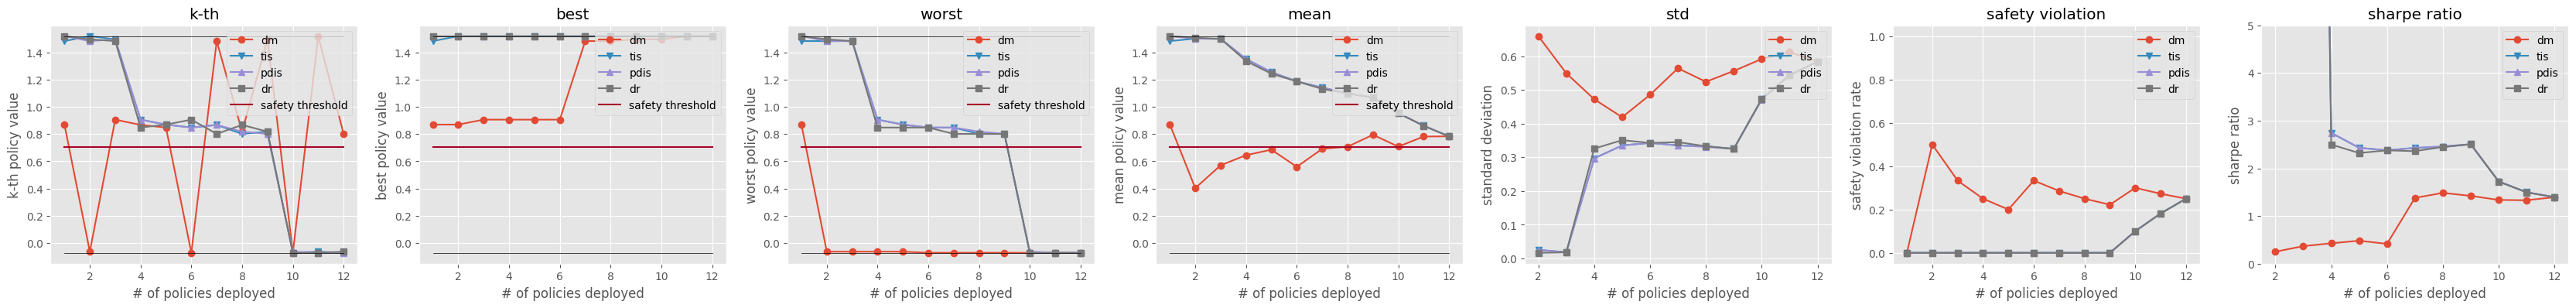

In [77]:
ops.visualize_topk_policy_value_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    relative_safety_criteria=1.0,
    ymax_sharpe_ratio=5.0,
    legend=True,
)

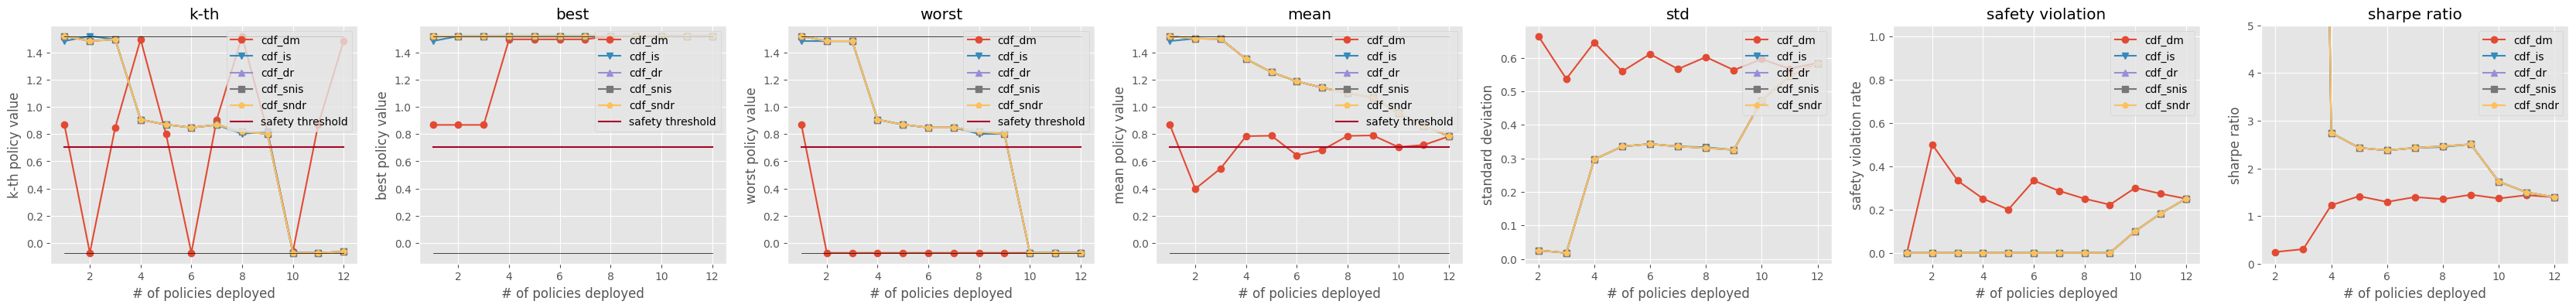

In [78]:
ops.visualize_topk_policy_value_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    relative_safety_criteria=1.0,
    ymax_sharpe_ratio=5.0,
    legend=True,
)

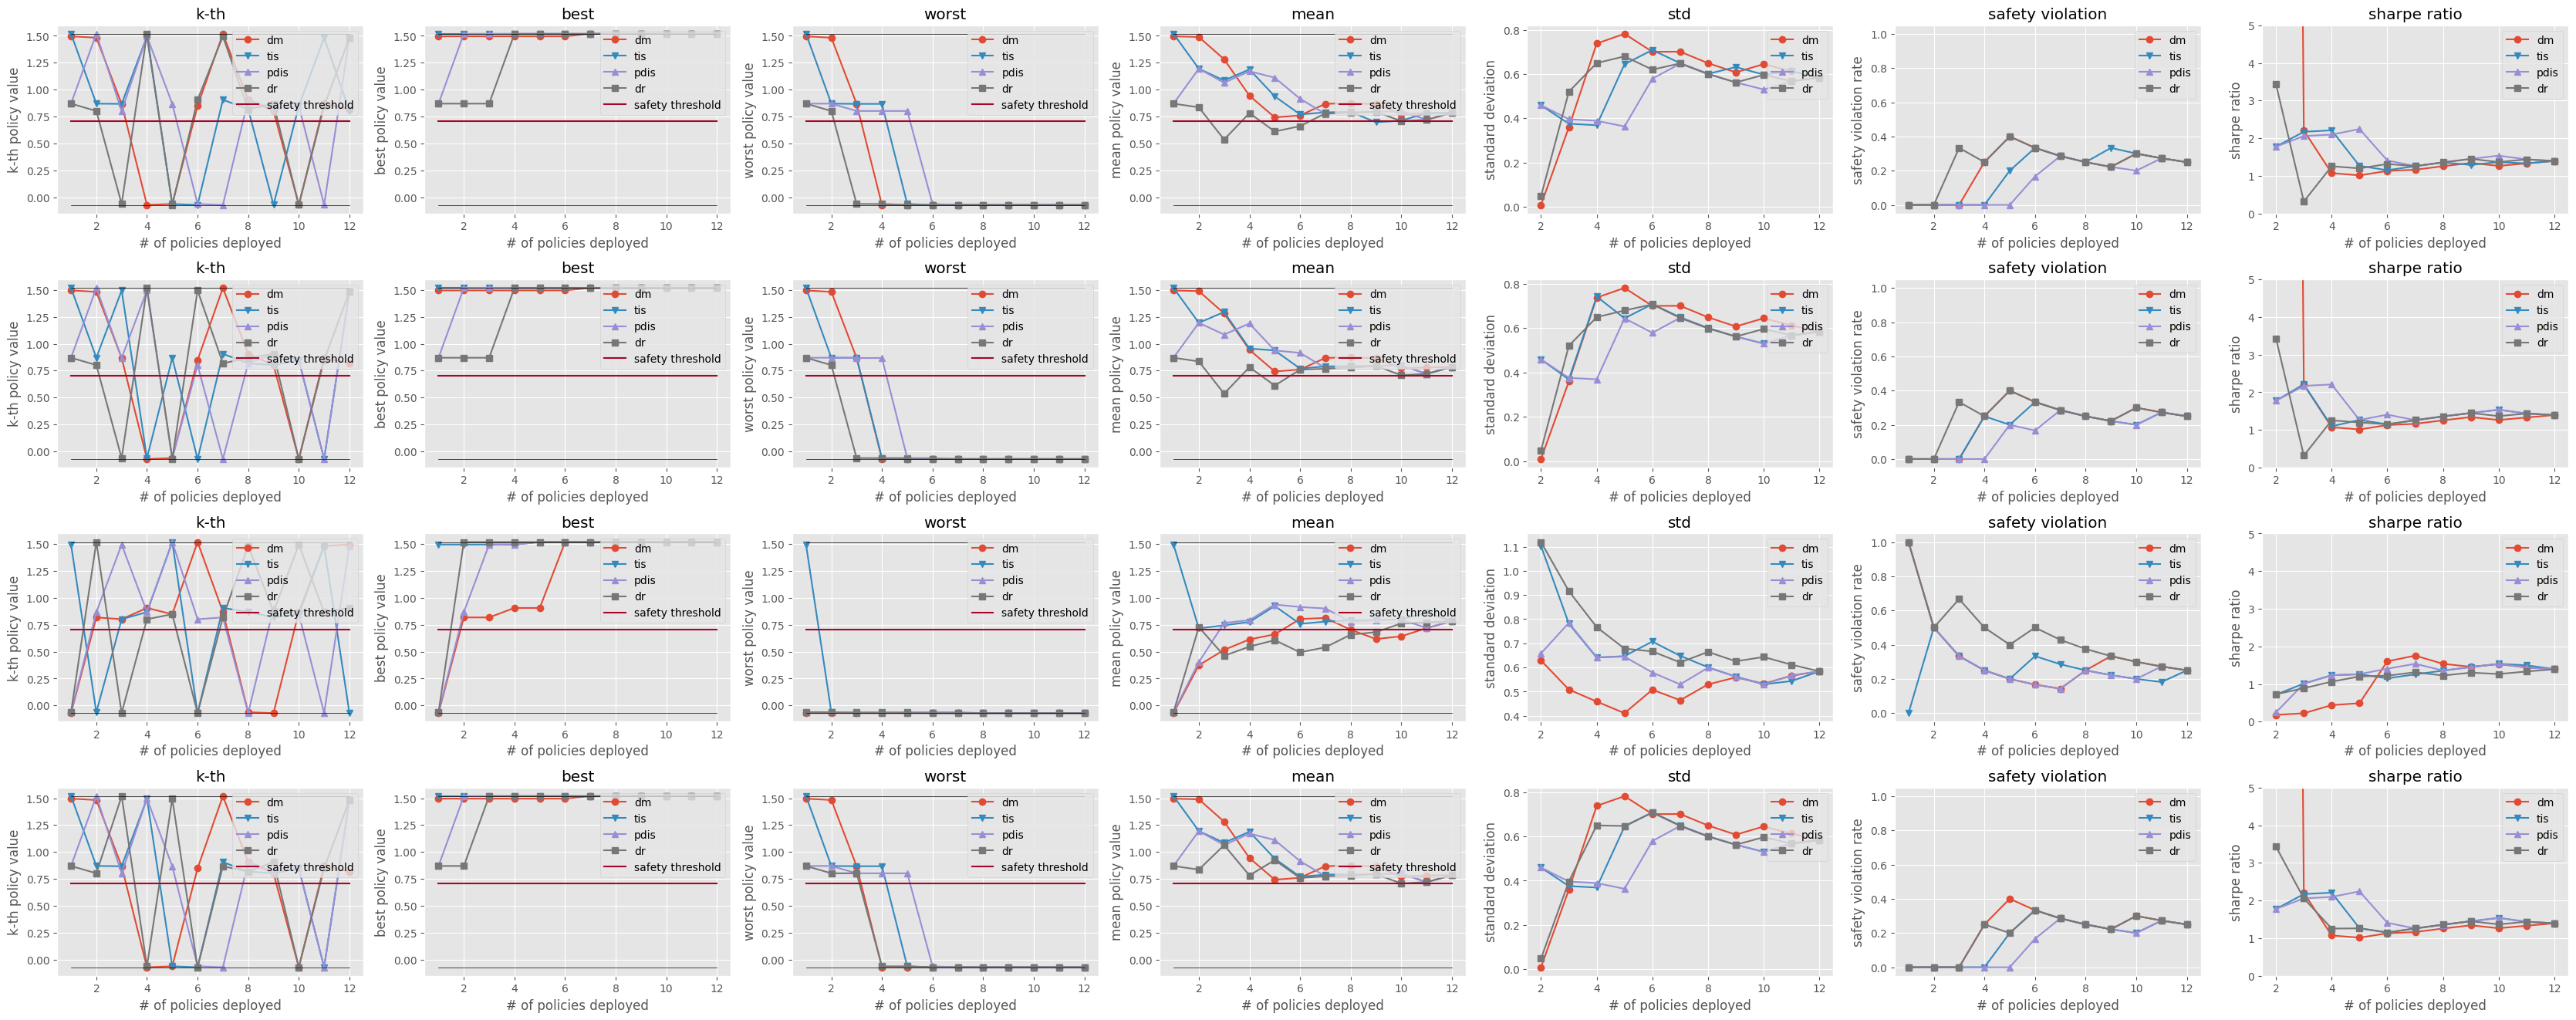

In [79]:
ops.visualize_topk_policy_value_selected_by_lower_bound(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_cis=["bootstrap", "bernstein", "hoeffding", "ttest"],
    relative_safety_criteria=1.0,
    ymax_sharpe_ratio=5.0,
    legend=True,
    random_state=12345,
)

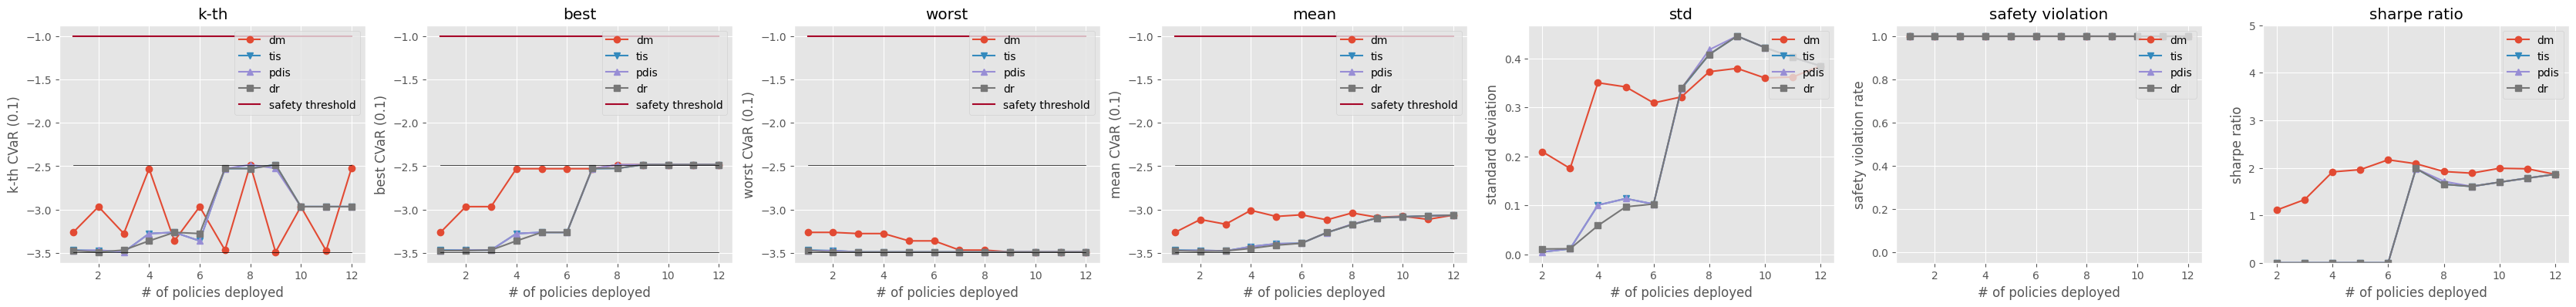

In [80]:
ops.visualize_topk_conditional_value_at_risk_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_alpha=0.10,
    safety_threshold=-1.0,
    ymax_sharpe_ratio=5.0,
    legend=True,
)

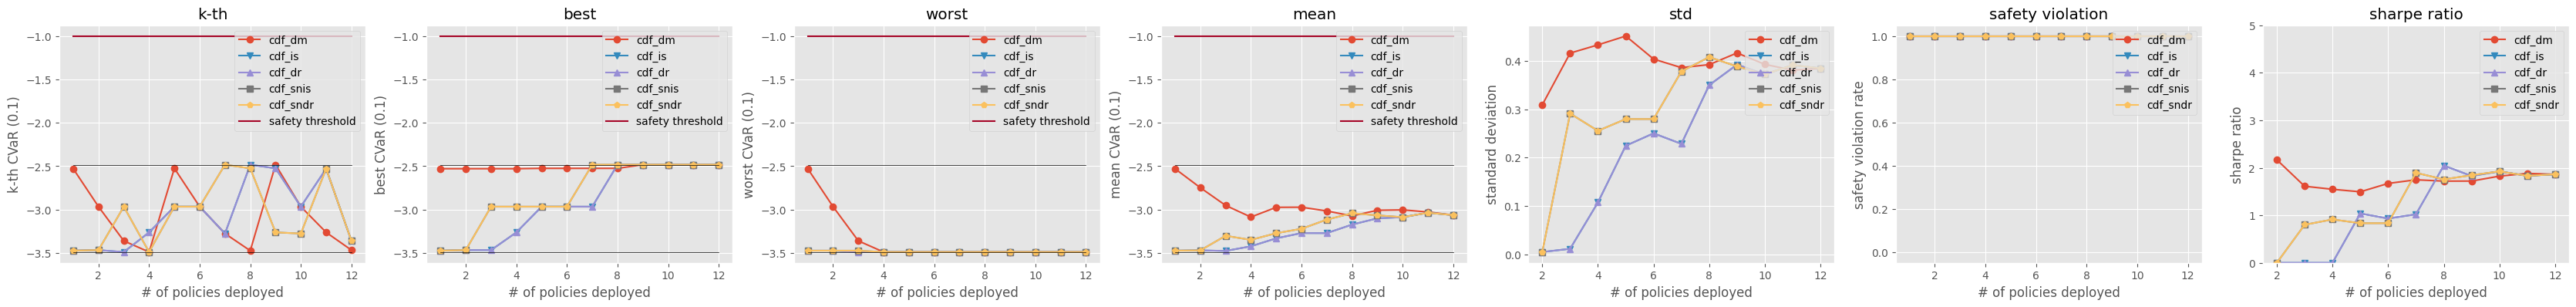

In [81]:
ops.visualize_topk_conditional_value_at_risk_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    ope_alpha=0.10,
    safety_threshold=-1.0,
    ymax_sharpe_ratio=5.0,
    legend=True,
)

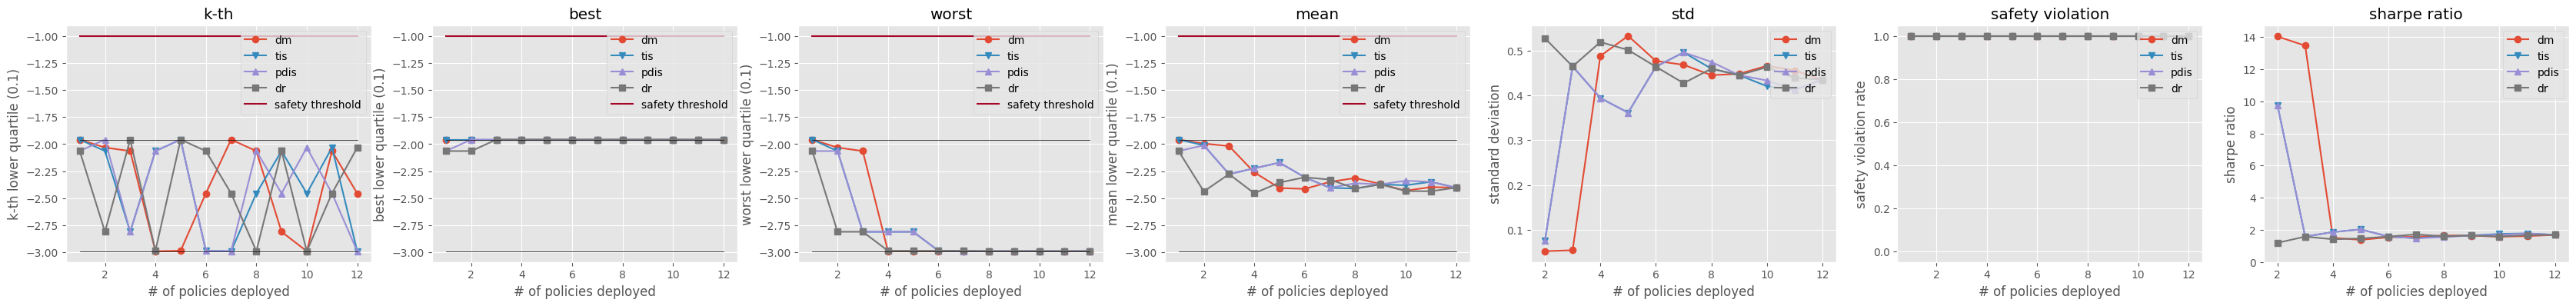

In [82]:
ops.visualize_topk_lower_quartile_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_alpha=0.10,
    safety_threshold=-1.0,
    legend=True,
)

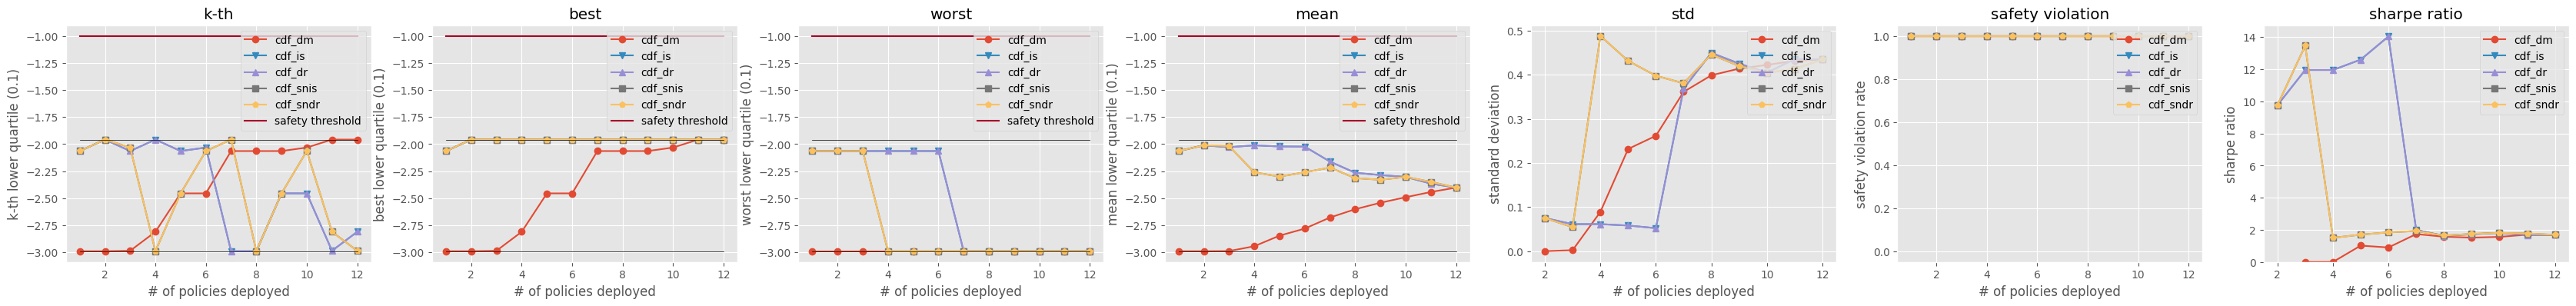

In [83]:
ops.visualize_topk_lower_quartile_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    ope_alpha=0.10,
    safety_threshold=-1.0,
    legend=True,
)

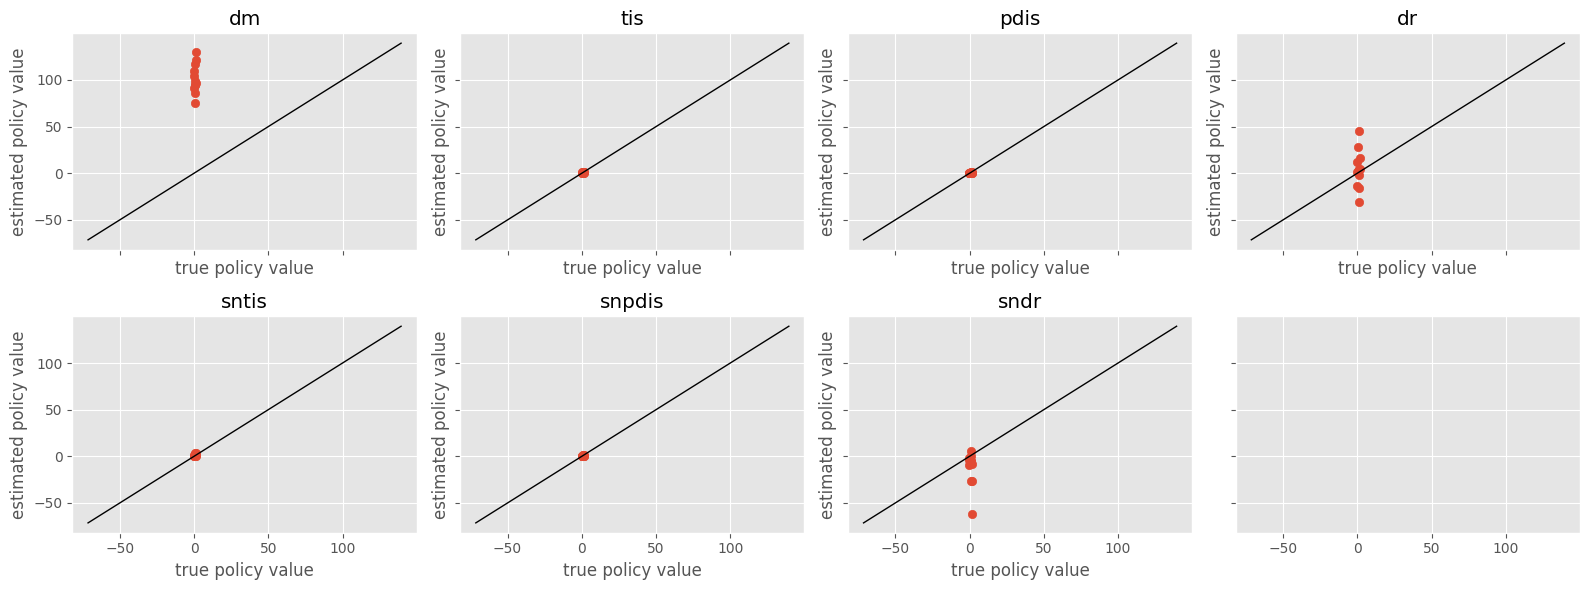

In [84]:
ops.visualize_policy_value_for_validation(
    input_dict=input_dict,
    n_cols=4,
    share_axes=True,
)

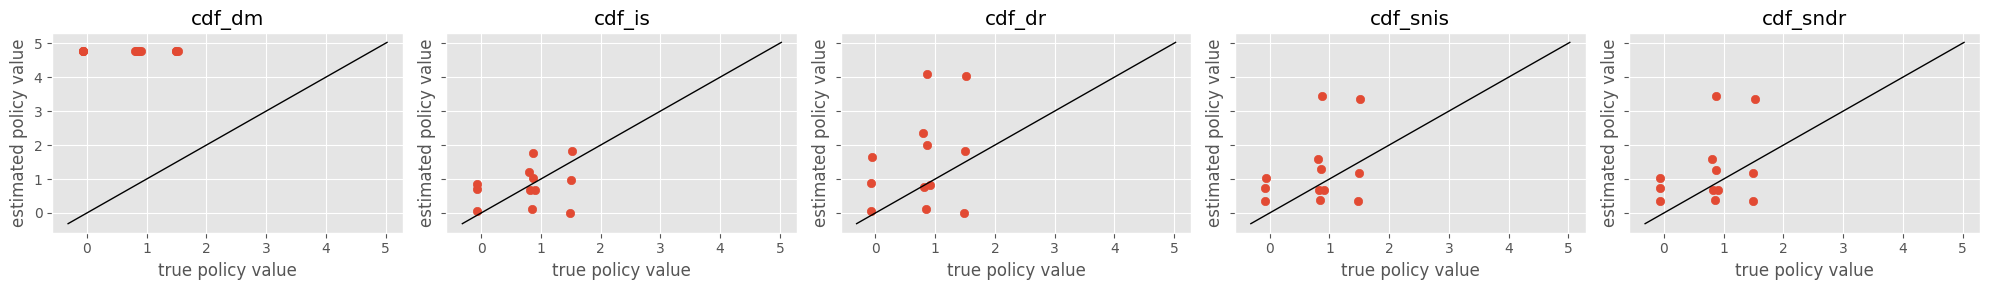

In [85]:
ops.visualize_policy_value_of_cumulative_distribution_ope_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

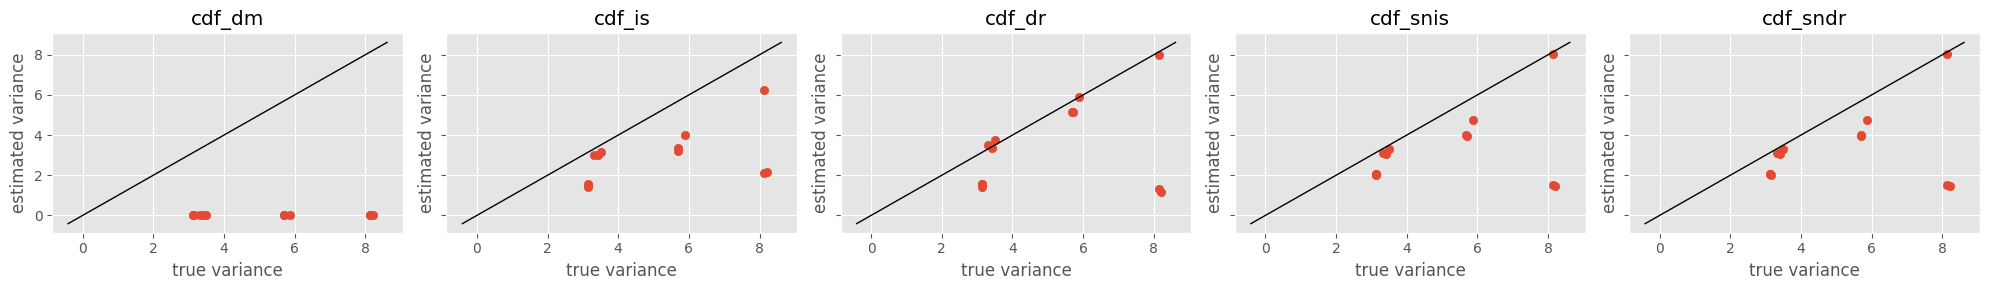

In [86]:
ops.visualize_variance_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

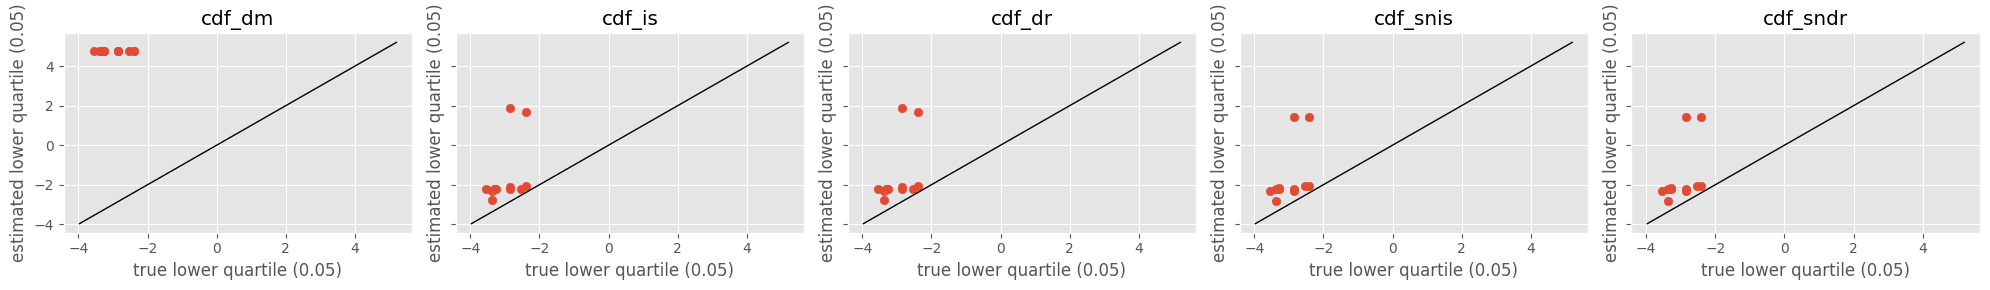

In [87]:
ops.visualize_lower_quartile_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

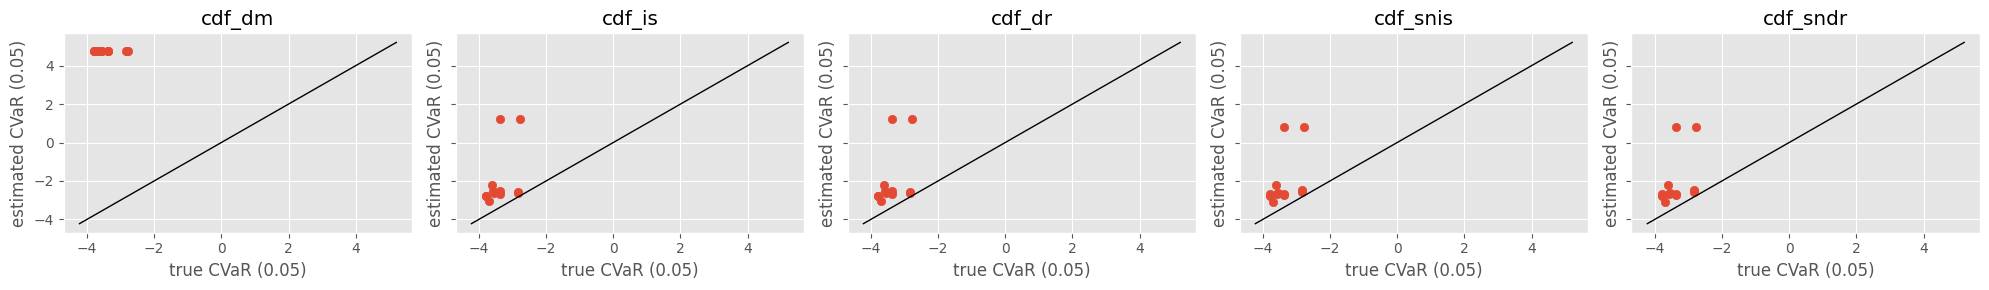

In [88]:
ops.visualize_conditional_value_at_risk_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

複数のデータセットでOPE/OPSを行う方法は，以下を参照してください．[examples/quickstart_ja/rec/rec_synthetic_discrete_multiple_datasets_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rec/rec_synthetic_discrete_multiple_datasets_ja.ipynb).

<!-- 連続的な行動空間に対する例は，以下を参照してください． [examples/quickstart_ja/rec/rec_synthetic_continuous_advanced_ja.ipynb](https://github.com/negocia-inc/scope_rl/blob/ope/examples/quickstart_ja/rec/rec_synthetic_continuous_advanced_ja.ipynb). -->

## 参考文献

- Vladislav Kurenkov and Sergey Kolesnikov. \
"Showing Your Offline Reinforcement Learning Work: Online Evaluation Budget Matters.", 2022.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment for Markov Decision Processes.", 2022.

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Shengpu Tang and Jenna Wiens. \
"Model Selection for Offline Reinforcement Learning: Practical Considerations for Healthcare Settings.", 2021.

- Justin Fu, Mohammad Norouzi, Ofir Nachum, George Tucker, Ziyu Wang, Alexander Novikov, Mengjiao Yang, Michael R. Zhang, Yutian Chen, Aviral Kumar, Cosmin Paduraru, Sergey Levine, and Tom Le Paine. \
"Benchmarks for Deep Off-Policy Evaluation.", 2021.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment in Contextual Bandits.", 2021.

- Yash Chandak, Scott Niekum, Bruno Castro da Silva, Erik Learned-Miller, Emma Brunskill, and Philip S. Thomas. \
"Universal Off-Policy Evaluation.", 2021.

- Sergey Levine, Aviral Kumar, George Tucker, and Justin Fu. \
"Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems." 2020.

- Tom Le Paine, Cosmin Paduraru, Andrea Michi, Caglar Gulcehre, Konrad Zolna, Alexander Novikov, Ziyu Wang, and Nando de Freitas. \
"Hyperparameter Selection for Offline Reinforcement Learning.", 2020.

- Aviral Kumar, Aurick Zhou, George Tucker, and Sergey Levine. \
"Conservative Q-Learning for Offline Reinforcement Learning.", 2020.

- Nathan Kallus and Masatoshi Uehara. \
"Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning.", 2019.

- Hoang Le, Cameron Voloshin, and Yisong Yue. \
"Batch Policy Learning under Constraints.", 2019.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Josiah P. Hanna, Peter Stone, and Scott Niekum. \
"Bootstrapping with Models: Confidence Intervals for Off-Policy Evaluation.", 2017.

- Nan Jiang and Lihong Li. \
"Doubly Robust Off-policy Value Evaluation for Reinforcement Learning.", 2016.

- Philip S. Thomas and Emma Brunskill. \
"Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning.", 2016.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Policy Improvement.", 2015.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Off-Policy Evaluation.", 2015.

- Adith Swaminathan and Thorsten Joachims. \
"The Self-Normalized Estimator for Counterfactual Learning.", 2015.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.

- Miroslav Dudík, Dumitru Erhan, John Langford, and Lihong Li. \
"Doubly Robust Policy Evaluation and Optimization.", 2014.

- Alex Strehl, John Langford, Sham Kakade, and Lihong Li. \
"Learning from Logged Implicit Exploration Data.", 2010.

- Alina Beygelzimer and John Langford. \
"The Offset Tree for Learning with Partial Labels.", 2009.

- Doina Precup, Richard S. Sutton, and Satinder P. Singh. \
"Eligibility Traces for Off-Policy Policy Evaluation.", 2000.